# Importing

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import optlib.optical as opt
import copy

plt.rcParams['font.size'] = 14
# from IPython.display import display, HTML

%matplotlib widget

**2. Path to the directory containing Henke ionisation data (download from https://henke.lbl.gov/optical_constants/asf.html)**

In [2]:
xraypath = '/Users/olgaridzel/Research/optical-data-fit/sf/'
# xraypath = '/home/fs70976/ridzel/db/sf/'

In [3]:
def plot_fit_results(osc, diimfp_coef, elf_coef, E0, exp_data):
    
    if (diimfp_coef > 0):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        osc.calculate_diimfp(E0)
        axs[0].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data (REELS)', c='tab:red', alpha=0.2)
        axs[0].plot(osc.diimfp_e,osc.diimfp,label=r'Fit with $\alpha = $' + f'{round(osc.oscillators.alpha, 2)}')
        axs[0].set_xlabel('Energy loss $\omega$ (eV)')
        axs[0].set_ylabel('nDIIMFP')
        axs[0].legend()
        axs[0].set_xlim(0,100)
        axis = 1
    else:
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        axis = 0

    if osc.oscillators.alpha == 0 or diimfp_coef == 0:
        eloss = osc.eloss_extended_to_henke
        elf = osc.elf_extended_to_henke
    else:
        eloss = osc.diimfp_e
        elf = osc.elf[:,0]

    axs[axis].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data (optical)', c='tab:red', alpha=0.5)
    axs[axis].plot(eloss,elf,label=r'Fit with $\alpha = $' + f'{round(osc.oscillators.alpha, 2)}')
    axs[axis].set_xlabel('Energy loss $\omega$ (eV)')
    axs[axis].set_ylabel('ELF')
    axs[axis].legend()
    axs[axis].set_xlim(0,100)

    fig.suptitle(f'Fitting results: {osc.name} {osc.oscillators.model} E0 = {E0/1000} keV')
    plt.show()

    plt.savefig(f'{osc.name}_{osc.oscillators.model}_fit.png', dpi=600)

# FITTING

## SiO2

In [4]:
# good ones
A = [0.133, 20.063, 60.847, 28.79, 8.277, 108.631, 55.902, 6.14, 55.588, 76.67]
gamma = [28.224, 2.216, 8.291, 2.389, 0.244, 6.651, 99.72, 99.994, 14.587, 20.676]
omega = [20.563, 13.513, 21.533, 11.86, 10.446, 16.839, 55.44, 74.406, 33.503, 50.332]
alpha = 0.995444904803041

M = (1 * 28.085 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 14 + 2 * 8) / (1 + 2)
rho = 2.19 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['si','o'], [1,2])
eloss = opt.linspace(0,100,0.1)
q = 0

sio2_drude = opt.Material('SiO2', oscillators, composition, eloss, q, xraypath)
sio2_drude.e_gap = 9
sio2_drude.width_of_the_valence_band = 10
sio2_drude.atomic_density = rho * opt.avogadro / M *1e-24
sio2_drude.static_refractive_index = 1.4585
sio2_drude.Z = Z_av
sio2_drude.use_henke_for_ne = True # 0.305
sio2_drude.use_kk_constraint = False
sio2_drude.use_kk_relation = False

fsum = sio2_drude.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sio2_drude.Z))

kksum = sio2_drude.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

FSum = 9.294070798694861
Z = 10.0
KKSum = 0.9590636778665418


Starting optimisation...


100%|██████████| 10000/10000 [02:51<00:00, 58.29it/s]


found minimum after 10000 evaluations
minimum value =  0.0012069303003119731
result code =  5
FSum = 9.277540926209122
Z = 10.0
KKSum = 0.9513369722899649
A = [0.167, 18.515, 70.158, 30.455, 7.178, 94.736, 48.06, 4.944, 65.47, 81.358]
gamma = [53.428, 2.407, 8.548, 2.617, 0.271, 6.275, 99.916, 99.993, 17.348, 25.968]
omega = [22.322, 13.554, 21.194, 11.959, 10.465, 16.747, 54.739, 90.483, 34.143, 52.622]
alpha = 0.9959737115680847


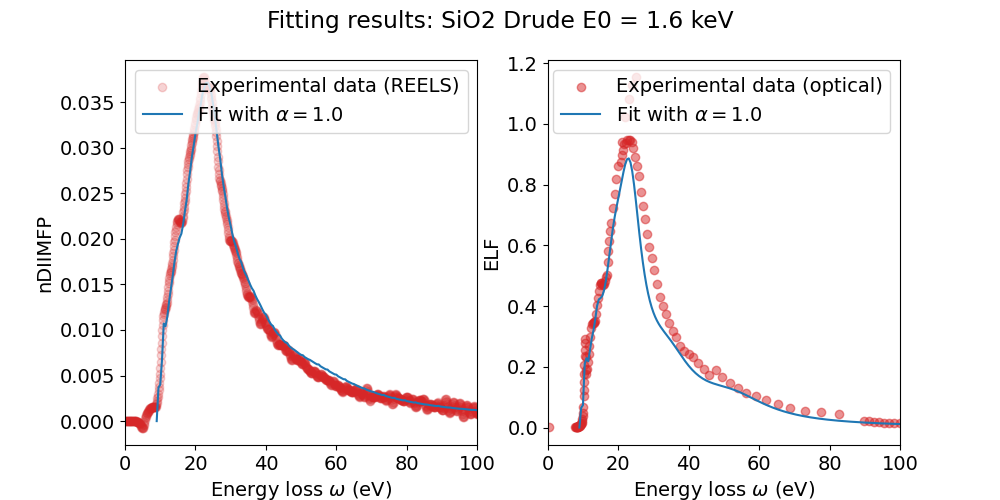

In [44]:
fd = pd.read_csv('../palik_data/sio2pal.txt',sep=' ',header=None)
exp_elf = fd.values

start_ind = 85
exp_eps1 = exp_elf[:,1]**2 - exp_elf[:,2]**2
exp_eps2 = 2 * exp_elf[:,1] * exp_elf[:,2]

x_exp = exp_elf[:,0]
y_exp = exp_eps2 / (exp_eps1**2 + exp_eps2**2)

x_exp_elf = x_exp[::-1][start_ind:]
y_exp_elf = y_exp[::-1][start_ind:]

fd = pd.read_csv('../diimfp/sio2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]
E0 = 1600

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

diimfp_coef = 0.99
elf_coef = 0.01

opt_ = opt.OptFit(sio2_drude, exp_data, E0, n_q = 8)
result = opt_.run_optimisation(diimfp_coef, elf_coef, maxeval = 10000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2struct(result)

fsum = oscOptimised.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')

# plot_fit_results(sio2_drude, 1, 1, E0, exp_data)
plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)
plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

In [45]:
plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

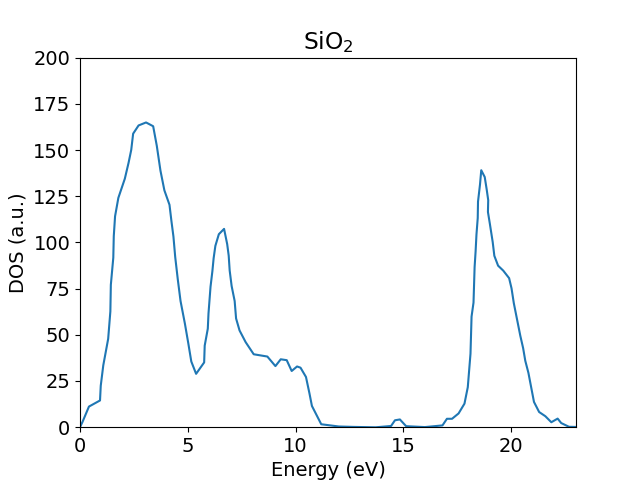

In [24]:
fd_sio2_dos = np.loadtxt("/Users/olgaridzel/Research/mast_sey/materials/sio2/spa/dos.in")

plt.figure()
plt.plot(fd_sio2_dos[:,0],fd_sio2_dos[:,1])
plt.xlim(0,23)
plt.ylim(0,200)
plt.xlabel("Energy (eV)")
plt.ylabel("DOS (a.u.)")
plt.title(r"SiO$_2$")
plt.show()

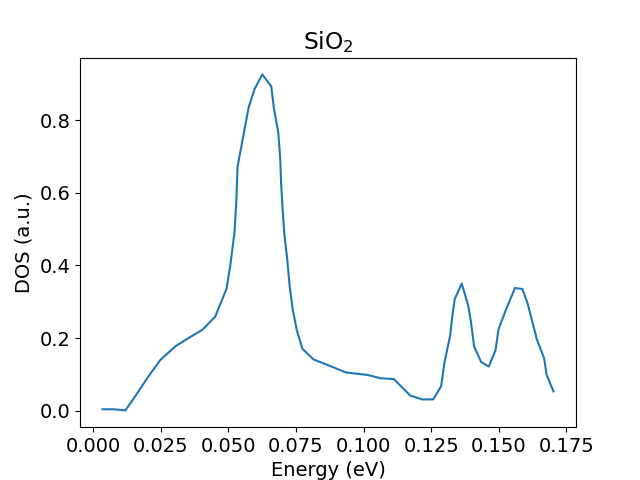

In [25]:
fd_sio2_phdos = np.loadtxt("/Users/olgaridzel/Research/mast_sey/materials/sio2/spa/phdos.in")

plt.figure()
plt.plot(fd_sio2_phdos[:,0],fd_sio2_phdos[:,1])
# plt.xlim(0,23)
# plt.ylim(0,200)
plt.xlabel("Energy (eV)")
plt.ylabel("DOS (a.u.)")
plt.title(r"SiO$_2$")
plt.show()

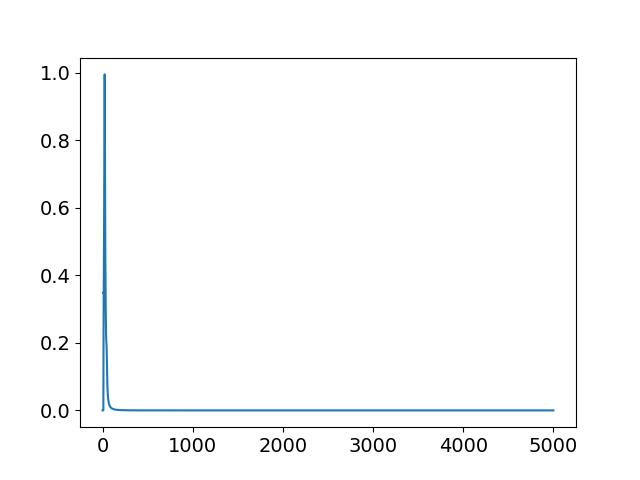

In [4]:
osc = sio2_drude

plt.figure()
osc.eloss = np.linspace(0,5000,10000)
osc.calculate_elf()
q_list = opt.linspace(0.0, 20, 0.02)

fd = open('/home/fs70976/ridzel/dev/mast_sey/materials/sio2/spa/elf.in', 'w')

# for q in q_list:
    # osc.q = q
    # osc.calculate_elf()
for i in range(len(osc.eloss)):
    fd.write(f'{osc.eloss[i]:.8f} {osc.elf[i]:.8f}\n')
# fd.write(f'{q} {q}\n')
# fd.write('99999999 99999999\n')
plt.plot(osc.eloss, osc.elf)
    
plt.show()
fd.close()

In [5]:
sio2_imfp = np.array([0.831,0.801,0.782,0.773,0.772,0.778,0.791,0.808,0.831,0.859,0.892,0.930,0.973,1.02,1.08,1.14,1.21,1.28,1.36,1.45,1.55,1.66,1.78,1.9,2.04,2.19,2.36,2.54,2.73,2.95,3.18,3.44,3.71,4.02,4.35,4.7,5.09,5.52,5.98,6.49,7.04,7.63,8.28,8.99,9.77,10.6,11.5,12.5,13.6,14.8,16.1,17.5,19,20.6,22.4,24.4,26.5,28.7,31.2,33.9,36.8,39.9,43.3,46.9,50.9,55.1,59.6,64.4,69.6,75.2,81,87.3,93.9,101,108,116,124,132,141,150,159,169,178])
sio2_imfp_e = np.array([54.6,60.3,66.7,73.7,81.5,90,99.5,109.9,121.5,134.3,148.4,164,181.3,200.3,221.4,244.7,270.4,298.9,330.3,365,403.4,445.9,492.7,544.6,601.8,665.1,735.1,812.4,897.8,992.3,1096.6,1212,1339.4,1480.3,1636,1808,1998.2,2208.3,2440.6,2697.3,2981,3294.5,3641,4023.9,4447.1,4914.8,5431.7,6002.9,6634.2,7332,8103.1,8955.3,9897.1,10938,12088.4,13359.7,14764.8,16317.6,18033.7,19930.4,22026.5,24343,26903.2,29732.6,32859.6,36315.5,40134.8,44355.9,49020.8,54176.4,59874.1,66171.2,73130.4,80821.6,89321.7,98715.8,109097.8,120571.7,133252.4,147266.6,162754.8,179871.9,198789.2])


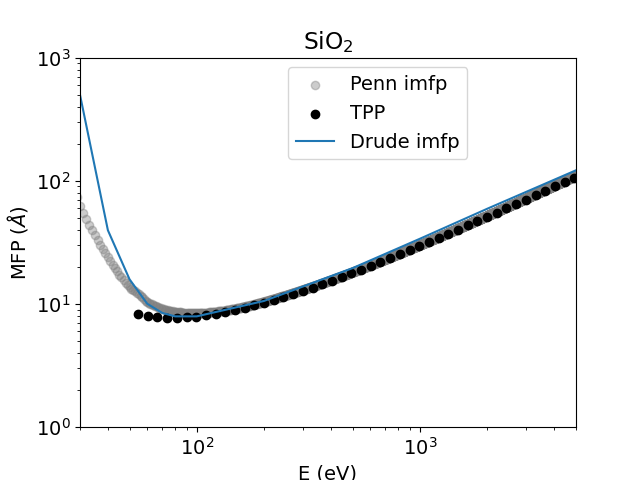

In [12]:
osc = sio2_drude
energy = np.array([30,40,50,60,70,80,90,100, 200, 500, 1000, 2000, 5000])
osc.calculate_imfp(energy, is_metal=False)

plt.figure()
plt.title(f'{osc.name.capitalize()}')

fd = np.loadtxt(f'/Users/olgaridzel/Research/PHYSDAT/dbi/diel/imfp/tpp/{osc.name.lower()}.iimfp')
plt.scatter(fd[:,0], fd[:,1],label='Penn imfp', color='gray', alpha=0.4)

plt.scatter(sio2_imfp_e,sio2_imfp*10,label='TPP',color='black')

plt.plot(energy,osc.imfp,label="Drude imfp")

# fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/sio2/spa/mfp.plot')
# plt.plot(fd[:,0], fd[:,1],label='imfp (SPA)',color='b')
# plt.plot(fd[:,0], fd[:,2],label='emfp',color='orange')

# fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/sio2/mll/mfp.plot')
# plt.plot(fd[:,0], fd[:,1],label='imfp (MLL)',color='r')

# plt.plot([13, 13], [1, 1000], color="black")
# plt.annotate(r"$U_i = 13$ eV", xy=(12.9, 700), xytext=(4.1, 1200), arrowprops=dict(arrowstyle="->"))

# plt.plot([4.8, 4.8], [1, 1000], "--", color="black")
# plt.annotate(r"E$_g$ = 4.8 eV", xy=(4.7, 5), xytext=(1.5, 1.4), arrowprops=dict(arrowstyle="->",linestyle="--"))

plt.xlabel("E (eV)")
# plt.xlabel(r"E - E$_g$ - E$_{vb}$ (eV)")
plt.ylabel(r"MFP ($\AA$)")
plt.title(r"SiO$_2$")
plt.xscale('log')
plt.yscale('log')
plt.xlim(30,5000)
plt.ylim(1,1000)
plt.legend(loc='upper center', bbox_to_anchor=(0.6, 1))
plt.show()

In [55]:
plt.savefig("imfp_sio2.png",dpi=600,bbox_inches='tight')

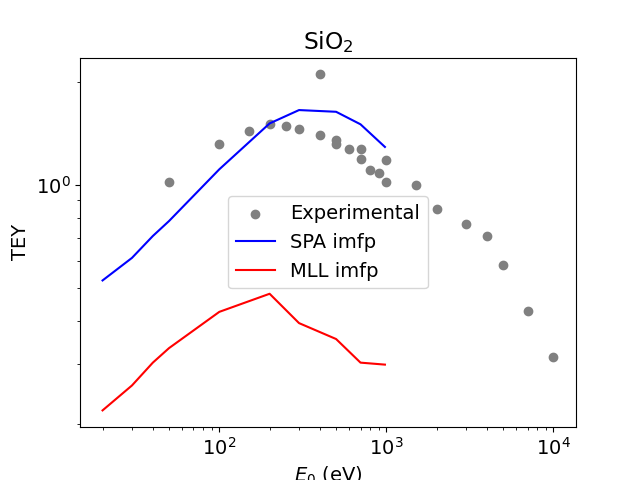

In [56]:
plt.figure()

plt.title(r'SiO$_2$')

fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/sio2/sey/sio2.see')
plt.scatter(fd[:,0]*1000, fd[:,1],label='Experimental',color='gray')

fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/sio2/spa/out/sey.plot')
plt.plot(fd[:,0], fd[:,1],label='SPA imfp',color='b')

fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/sio2/mll/out/sey.plot')
plt.plot(fd[:,0], fd[:,1],label='MLL imfp',color='r')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$E_0$ (eV)')
plt.ylabel('TEY')
plt.legend()

plt.show()

In [57]:
plt.savefig("tey_sio2.png",dpi=600,bbox_inches='tight')

In [9]:
A = [0.012, 0.091, 0.253, 0.042, 0.004, 0.128]
gamma = [27.521, 5.239, 7.905, 3.432, 7.451, 23.896]
omega = [9.818, 19.725, 24.379, 14.733, 30.839, 39.906]
alpha = 0.92449

M = (1 * 28.085 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 14 + 2 * 8) / (1 + 2)
rho = 2.19 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['si','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

sio2_dl = opt.Material('SiO2', oscillators, composition, eloss, q, xraypath)
sio2_dl.e_gap = 9.1
sio2_dl.width_of_the_valence_band = 10
sio2_dl.atomic_density = rho * opt.avogadro / M *1e-24
sio2_dl.static_refractive_index = 1.4585
# sio2_dl.electron_density = sio2_dl.atomic_density * 16
sio2_dl.Z = Z_av
sio2_dl.use_henke_for_ne = True
sio2_dl.use_kk_constraint = False
sio2_dl.use_kk_relation = False

fsum = sio2_dl.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sio2_dl.Z))

kksum = sio2_dl.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

FSum = 9.311045962675012
Z = 10.0
KKSum = 0.9522723103561647


In [12]:
fd = pd.read_csv('../palik_data/sio2pal.txt',sep=' ',header=None)
exp_elf = fd.values

start_ind = 85
exp_eps1 = exp_elf[:,1]**2 - exp_elf[:,2]**2
exp_eps2 = 2 * exp_elf[:,1] * exp_elf[:,2]

x_exp = exp_elf[:,0]
y_exp = exp_eps2 / (exp_eps1**2 + exp_eps2**2)

x_exp_elf = x_exp[::-1][start_ind:]
y_exp_elf = y_exp[::-1][start_ind:]

fd = pd.read_csv('../diimfp/sio2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(sio2_dl, exp_data, 1600, n_q = 6)
result = opt_.run_optimisation(0.9, 0.1, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# plot_fit_results(sio2_dl, E0, exp_data)
plot_fit_results(oscOptimised, E0, exp_data)

In [10]:
osc = sio2_dl
osc.convert_to_mll()
sio2_mll = osc
sio2_mll.u = sio2_mll.e_gap
sio2_mll.oscillators.model = 'MLL'

fsum = sio2_mll.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sio2_mll.Z))

kksum = sio2_mll.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in sio2_mll.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in sio2_mll.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in sio2_mll.oscillators.omega.round(3).tolist()])}]')
print(f'U = {sio2_mll.u}')

current_u 1.0 u_step_size 1.0
current_u 2.0 u_step_size 1.0
current_u 3.0 u_step_size 1.0
current_u 4.0 u_step_size 1.0
current_u 5.0 u_step_size 1.0
current_u 6.0 u_step_size 1.0
current_u 7.0 u_step_size 1.0
current_u 8.0 u_step_size 1.0
current_u 9.0 u_step_size 1.0
current_u 10.0 u_step_size 1.0
new_sum_A 0.6892275644102583
current_u 9.1 u_step_size 0.1
current_u 9.2 u_step_size 0.1
current_u 9.299999999999999 u_step_size 0.1
current_u 9.399999999999999 u_step_size 0.1
current_u 9.499999999999998 u_step_size 0.1
current_u 9.599999999999998 u_step_size 0.1
current_u 9.699999999999998 u_step_size 0.1
new_sum_A 0.9052124267200152
current_u 9.609999999999998 u_step_size 0.01
current_u 9.619999999999997 u_step_size 0.01
current_u 9.629999999999997 u_step_size 0.01
current_u 9.639999999999997 u_step_size 0.01
current_u 9.649999999999997 u_step_size 0.01
current_u 9.659999999999997 u_step_size 0.01
new_sum_A 0.9872491508860431
current_u 9.650999999999996 u_step_size 0.001
current_u 9.6519

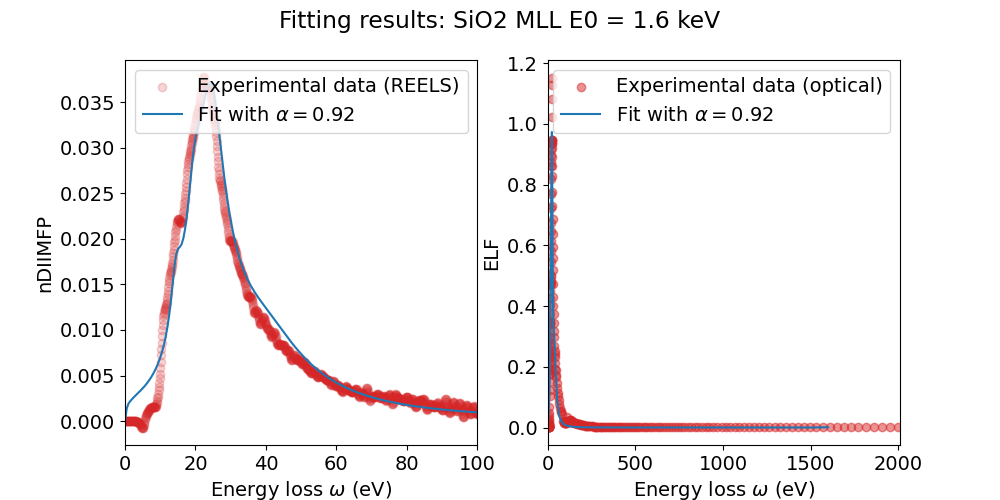

In [25]:
sio2_mll.e_gap = 0
plot_fit_results(sio2_mll, 1, 1, 1600, exp_data)

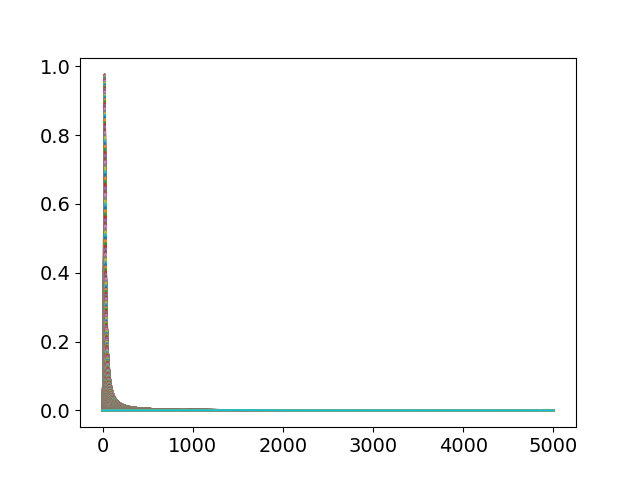

In [33]:
osc = sio2_mll

plt.figure()
osc.eloss = np.linspace(0,5000,10000)
osc.calculate_elf()
q_list = opt.linspace(0.01, 20, 0.02)

fd = open('/home/fs70976/ridzel/dev/mast_sey/materials/sio2/mll/elf.in', 'w')

for q in q_list:
    osc.q = q
    osc.calculate_elf()
    osc.elf[osc.elf < 0] = 0.0
    for i in range(len(osc.eloss)):
        fd.write(f'{osc.eloss[i]:.8f} {osc.elf[i]:.8f}\n')
    if (q == 0.01):
        fd.write('0.0 0.0\n')
    else:
        fd.write(f'{q} {q}\n')
    fd.write('99999999 99999999\n')
    plt.plot(osc.eloss, osc.elf)

# plt.ylim(0, 1)
plt.show()
fd.close()

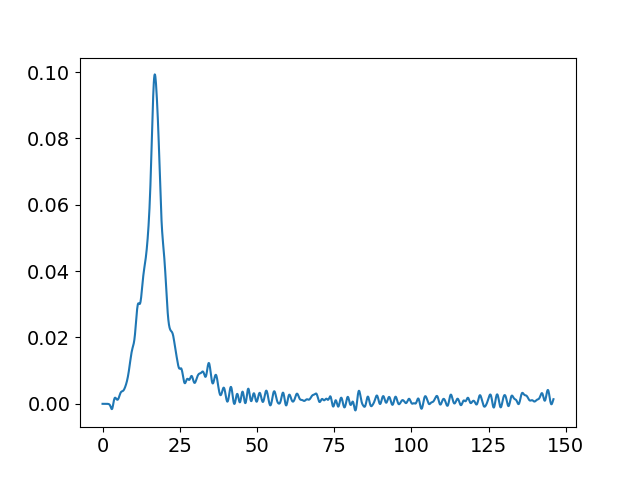

In [68]:
fd = np.loadtxt("/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/si.wo",usecols=[0,1])

plt.figure()
plt.plot(fd[:,0],fd[:,1])
plt.show()

In [71]:
A = [0.015, 0.1, 0.29, 0.39, 0.068, 0.035, 0.011, 0.006, 0.002]
gamma = [2, 2.5, 2.2, 2.3, 4, 6, 40, 80, 150]
omega = [5.5, 13.5, 15.7, 17.2, 20, 25, 130, 180, 280]
alpha = 1

M = 28.085 # Molar weight
Z_av = 14
rho = 2.33 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['si'], [1])
eloss = opt.linspace(1e-5,100,0.1)
q = 0

si = opt.Material('Si', oscillators, composition, eloss, q, xraypath)
si.e_fermi = 12.5
si.atomic_density = rho * opt.avogadro / M *1e-24
si.static_refractive_index = 1.4585
si.electron_density = si.atomic_density * 4
si.Z = Z_av
si.use_henke_for_ne = False
si.use_kk_constraint = False
si.use_kk_relation = False

fsum = si.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(si.Z))

kksum = si.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

FSum = 14.065189400736847
Z = 14
KKSum = 0.9183814903274253


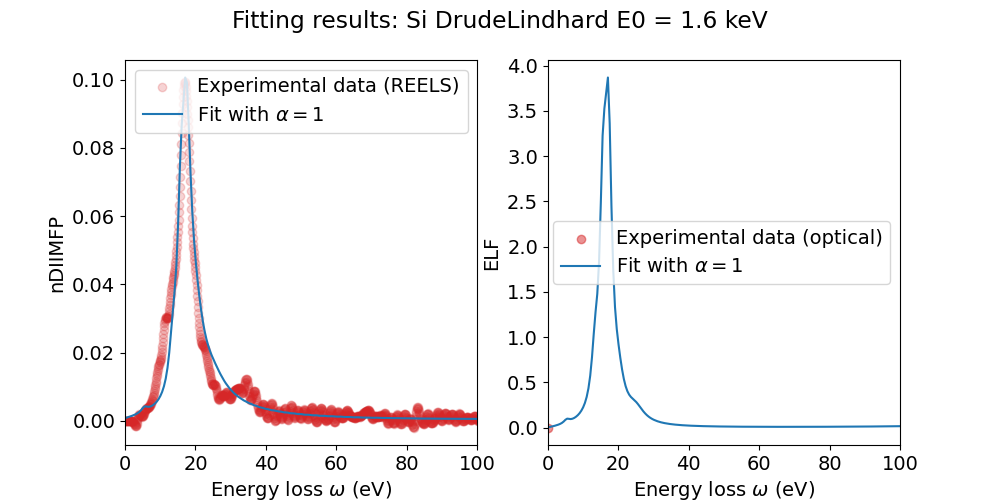

In [72]:
fd = np.loadtxt("/Users/olgaridzel/Research/olga-optical-data/MATLAB/diimfp/wolga/si.wo",usecols=[0,1])
x_exp_ndiimfp = fd[:,0]
y_exp_ndiimfp = fd[:,1]
E0 = 1600

exp_data = opt.exp_data()
exp_data.x_elf = 0
exp_data.y_elf = 0
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

diimfp_coef = 1
elf_coef = 0

# opt_ = opt.OptFit(si, exp_data, E0, n_q = 8)
# result = opt_.run_optimisation(diimfp_coef, elf_coef, maxeval = 10000, xtol_rel = 1e-4)
# oscOptimised = opt_.vec2struct(result)

# fsum = oscOptimised.evaluate_f_sum()
# print('FSum = {}'.format(fsum))
# print('Z = {}'.format(oscOptimised.Z))

# kksum = oscOptimised.evaluate_kk_sum()
# print('KKSum = {}'.format(kksum))

# print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
# print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
# print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
# print(f'alpha = {oscOptimised.oscillators.alpha}')

plot_fit_results(si, 1, 1, E0, exp_data)
# plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)
# plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

## MgO

In [52]:
A = [0.149, 19.37, 55.901, 36.606, 11.748, 144.497, 39.879, 1.857, 53.445, 34.072]
gamma = [8.318, 1.83, 9.708, 1.756, 0.355, 7.375, 99.332, 99.991, 17.418, 11.506]
omega = [20.766, 13.743, 22.542, 11.806, 10.405, 16.916, 40.411, 49.59, 32.971, 44.971]
alpha = 0.8900859116271297

M = (1 * 24.305 + 1 * 15.999) / (1 + 1) # Molar weight
Z_av = (1 * 12 + 1 * 8) / (1 + 1)
rho = 3.576 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['mg','o'], [1,1])
eloss = opt.linspace(0,100,0.1)
q = 0

mgo_drude = opt.Material('MgO', oscillators, composition, eloss, q, xraypath)
mgo_drude.e_gap = 7.69
mgo_drude.width_of_the_valence_band = 6.3
mgo_drude.atomic_density = rho * opt.avogadro / M *1e-24
mgo_drude.static_refractive_index = 1.7375
mgo_drude.Z = Z_av
mgo_drude.use_henke_for_ne = True
mgo_drude.use_kk_constraint = False
mgo_drude.use_kk_relation = False

fsum = mgo_drude.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(mgo_drude.Z))

kksum = mgo_drude.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

FSum = 7.715580906330008
Z = 10.0
KKSum = 0.8744288842203027


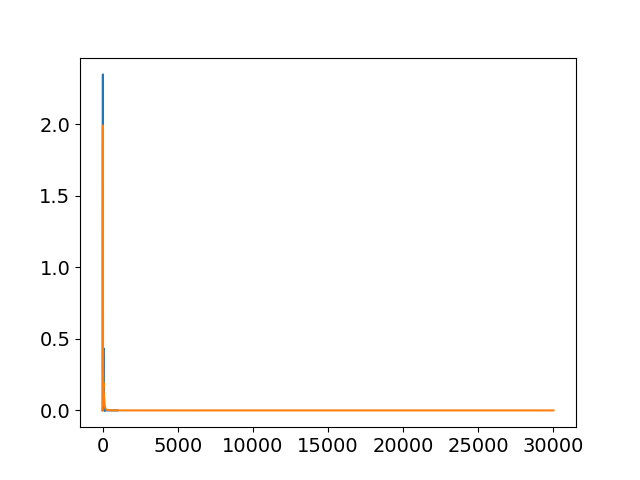

In [56]:
fd = np.loadtxt("/Users/olgaridzel/Research/mast_sey/materials/mgo/spa/elfff")

plt.figure()
plt.plot(fd[:,0],fd[:,1])
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/mgo.diel')
plt.plot(fd[:,0],fd[:,3])
plt.show()

3.01890625

Starting optimisation...


100%|██████████| 5000/5000 [00:06<00:00, 762.70it/s]


found minimum after 5000 evaluations
minimum value =  0.0025644165826016526
result code =  5
FSum = 9.22559853096553
Z = 10.0
KKSum = 0.9701128412053026
A = [0.284, 21.35, 111.869, 67.301, 13.748, 163.908, 60.523, 2.419, 169.557, 79.371]
gamma = [5.995, 2.737, 35.516, 2.542, 0.87, 4.955, 99.65, 99.998, 21.731, 15.895]
omega = [18.067, 19.803, 12.27, 17.457, 10.657, 12.726, 50.189, 107.464, 63.327, 36.359]
alpha = 0.8912232092829613


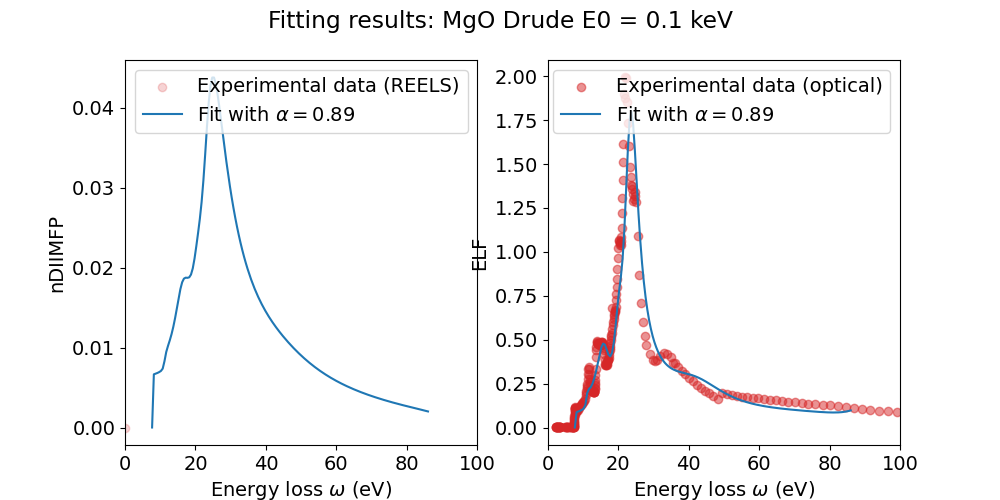

In [59]:
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/mgo.diel')
x_exp_elf = fd[:,0]
y_exp_elf = fd[:,3]

x_exp_ndiimfp = 0
y_exp_ndiimfp = 0

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(mgo_drude, exp_data, 100, n_q = 6)
result = opt_.run_optimisation(0.0, 1.0, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2struct(result)

# oscOptimised = mgo_drude

fsum = oscOptimised.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')

plot_fit_results(oscOptimised, 1, 1, 100, exp_data)


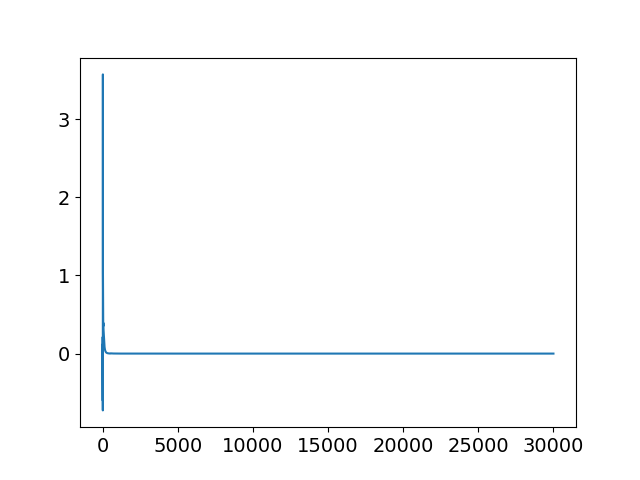

In [15]:
plt.figure()

fd = open('/Users/olgaridzel/Research/mast_sey/materials/mgo/spa/elf.in', 'w')

for i in range(len(x_exp_elf)):
    fd.write(f'{x_exp_elf[i]:.8f} {y_exp_elf[i]:.8f}\n')
plt.plot(x_exp_elf,y_exp_elf)
plt.show()
fd.close()

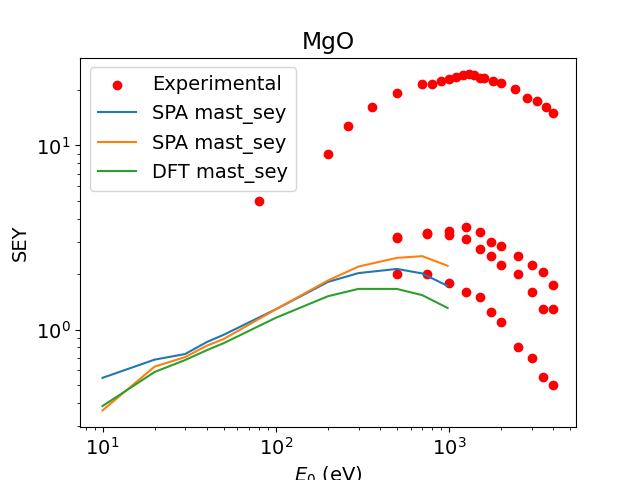

In [17]:
plt.figure()

plt.title('MgO')

fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/mgo/sey/mgo.sey')
plt.scatter(fd[:,0]*1000, fd[:,1],label='Experimental',color='red')

fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/mgo/spa/out/sey.plot')
plt.plot(fd[:,0], fd[:,1],label='SPA mast_sey')
fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/mgo/dft/out/sey12.plot')
plt.plot(fd[:,0], fd[:,1],label='SPA mast_sey')
fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/mgo/dft/out/sey.plot')
plt.plot(fd[:,0], fd[:,1],label='DFT mast_sey')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$E_0$ (eV)')
plt.ylabel('SEY')
plt.legend()

plt.show()

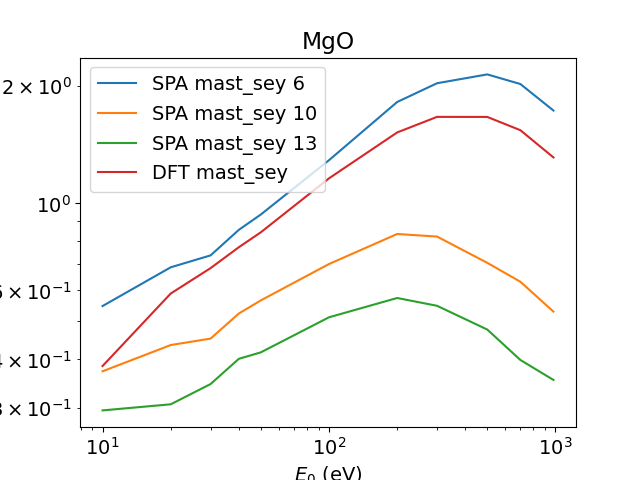

In [61]:
plt.figure()

plt.title('MgO')

# fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/sio2/sey/sio2.see')
# plt.scatter(fd[:,0]*1000, fd[:,1],label='Experimental',color='red')

fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/mgo/spa/out/sey.plot')
plt.plot(fd[:,0], fd[:,1],label='SPA mast_sey 6')
fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/mgo/spa/out/sey10.plot')
plt.plot(fd[:,0], fd[:,1],label='SPA mast_sey 10')
fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/mgo/spa/out/sey13.plot')
plt.plot(fd[:,0], fd[:,1],label='SPA mast_sey 13')

fd = np.loadtxt('/Users/olgaridzel/Research/mast_sey/materials/mgo/dft/out/sey.plot')
plt.plot(fd[:,0], fd[:,1],label='DFT mast_sey')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$E_0$ (eV)')
plt.ylabel('SEY')
plt.legend()

plt.show()

### DL

In [20]:
A = [0.012, 0.091, 0.253, 0.042, 0.004, 0.128]
gamma = [27.521, 5.239, 7.905, 3.432, 7.451, 23.896]
omega = [9.818, 19.725, 24.379, 14.733, 30.839, 39.906]
alpha = 0.92449

M = (1 * 24.305 + 1 * 15.999) / (1 + 1) # Molar weight
Z_av = (1 * 12 + 1 * 8) / (1 + 1)
rho = 3.576 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['mg','o'], [1,1])
eloss = opt.linspace(0,100,0.1)
q = 0

mgo_drude = opt.Material('MgO', oscillators, composition, eloss, q, xraypath)
mgo_drude.e_gap = 7.69
mgo_drude.width_of_the_valence_band = 6.3
mgo_drude.atomic_density = rho * opt.avogadro / M *1e-24
mgo_drude.static_refractive_index = 1.7375
mgo_drude.Z = Z_av
mgo_drude.use_henke_for_ne = True
mgo_drude.use_kk_constraint = False
mgo_drude.use_kk_relation = False

fsum = mgo_drude.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(mgo_drude.Z))

kksum = mgo_drude.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

FSum = 7.754058214231897
Z = 10.0
KKSum = 0.8328235470072134


Starting optimisation...


100%|██████████| 5000/5000 [01:37<00:00, 51.05it/s]


found minimum after 5000 evaluations
minimum value =  0.07869092053844921
result code =  5
FSum = 10.072931327274707
Z = 10.0
KKSum = 0.9824271477252856
A = [0.011, 0.141, 0.316, 0.035, 0.009, 0.157]
gamma = [60.635, 1.613, 2.385, 6.109, 7.127, 28.775]
omega = [11.282, 25.781, 23.946, 13.124, 37.413, 58.521]
alpha = 0.9329202875695868


(0.0, 100.0)

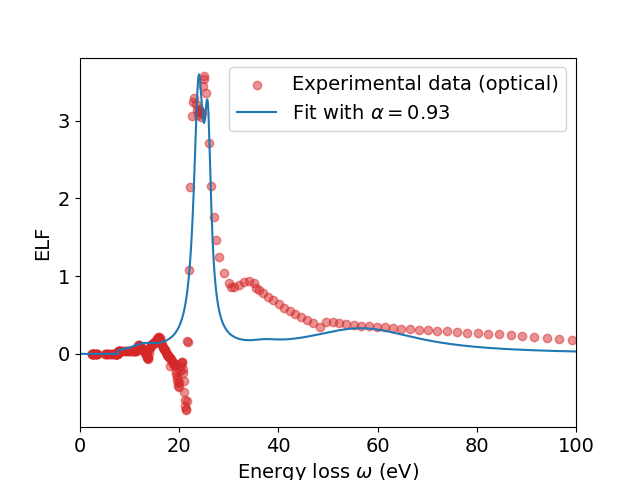

In [21]:
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/mgo.diel')
exp_eps1 = fd[:,1]**2 - fd[:,2]**2
exp_eps2 = 2 * fd[:,1] * fd[:,2]

x_exp_elf = fd[:,0]
y_exp_elf = exp_eps2 / (exp_eps1**2 + exp_eps2**2)

x_exp_ndiimfp = 0
y_exp_ndiimfp = 0

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(mgo_drude, exp_data, 100, n_q = 8)
result = opt_.run_optimisation(0.0, 1.0, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2struct(result)

fsum = oscOptimised.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

plt.figure()
oscOptimised.calculate_elf()
plt.scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data (optical)', c='tab:red', alpha=0.5)
plt.plot(oscOptimised.eloss,oscOptimised.elf,label=r'Fit with $\alpha = $' + f'{round(oscOptimised.oscillators.alpha, 2)}')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.legend()
plt.xlim(0,100)



In [ ]:
osc = oscOptimised
osc.convert_to_mll()
mgo_mll = osc
mgo_mll.u = mgo_mll.e_gap
mgo_mll.oscillators.model = 'MLL'

fsum = mgo_mll.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(mgo_mll.Z))

kksum = mgo_mll.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in mgo_mll.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in mgo_mll.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in mgo_mll.oscillators.omega.round(3).tolist()])}]')
print(f'U = {mgo_mll.u}')

In [ ]:
osc = sio2_mll

plt.figure()
osc.eloss = np.linspace(0,5000,10000)
osc.calculate_elf()
q_list = opt.linspace(0.01, 20, 0.02)

fd = open('/home/fs70976/ridzel/dev/mast_sey/materials/sio2/mll/elf.in', 'w')

for q in q_list:
    osc.q = q
    osc.calculate_elf()
    osc.elf[osc.elf < 0] = 0.0
    for i in range(len(osc.eloss)):
        fd.write(f'{osc.eloss[i]:.8f} {osc.elf[i]:.8f}\n')
    if (q == 0.01):
        fd.write('0.0 0.0\n')
    else:
        fd.write(f'{q} {q}\n')
    fd.write('99999999 99999999\n')
    plt.plot(osc.eloss, osc.elf)

# plt.ylim(0, 1)
plt.show()
fd.close()

## CaF2

In [40]:
A = [95.074, 30.519, 26.57, 68.419, 74.451, 30.046, 82.997, 67.205, 39.599, 47.866, 46.321, 38.49]
gamma = [30.394, 54.635, 1.286, 2.005, 6.277, 11.905, 3.257, 79.023, 6.885, 2.461, 43.405, 10.517]
omega = [73.046, 108.191, 11.834, 32.742, 25.611, 36.091, 14.407, 48.613, 22.28, 30.753, 60.979, 44.593]
alpha = 0.571422

M = (1 * 40.078 + 2 * 18.998) / (1 + 2) # Molar weight
Z_av = (1 * 20 + 2 * 9) / (1 + 2)
rho = 3.18 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['ca','f'], [1,2])
eloss = opt.linspace(1e-5,100,0.1)
q = 0

caf2_drude = opt.Material('CaF2', oscillators, composition, eloss, q, xraypath)
caf2_drude.e_gap = 10
caf2_drude.width_of_the_valence_band = 5.84
caf2_drude.atomic_density = rho * opt.avogadro / M *1e-24
caf2_drude.static_refractive_index = 1.4338
# caf2_drude.electron_density = 0.305
caf2_drude.Z = Z_av
caf2_drude.use_henke_for_ne = True
caf2_drude.use_kk_relation = False

fsum = caf2_drude.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(caf2_drude.Z))

kksum = caf2_drude.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

FSum = 11.479702774825096
Z = 12.666666666666666
KKSum = 0.9761545580586461


Starting optimisation...


100%|██████████| 10000/10000 [03:10<00:00, 52.51it/s]
/var/folders/78/79wz_ytd2w1gq25wlps382hw0000gn/T/ipykernel_2290/1511308054.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


found minimum after 10000 evaluations
minimum value =  5.966726387754038e-07
result code =  5
FSum = 11.341876913132513
Z = 12.666666666666666
KKSum = 0.9664374146906349
A = [90.103, 50.355, 24.033, 69.903, 71.307, 30.062, 80.459, 60.879, 46.173, 37.539, 49.381, 37.326]
gamma = [30.95, 79.448, 1.366, 2.108, 6.355, 11.723, 3.31, 93.731, 6.543, 2.506, 41.149, 9.912]
omega = [73.12, 105.033, 11.602, 32.671, 26.4, 34.953, 14.378, 49.415, 22.657, 31.323, 60.219, 44.729]
alpha = 0.5903995590534562


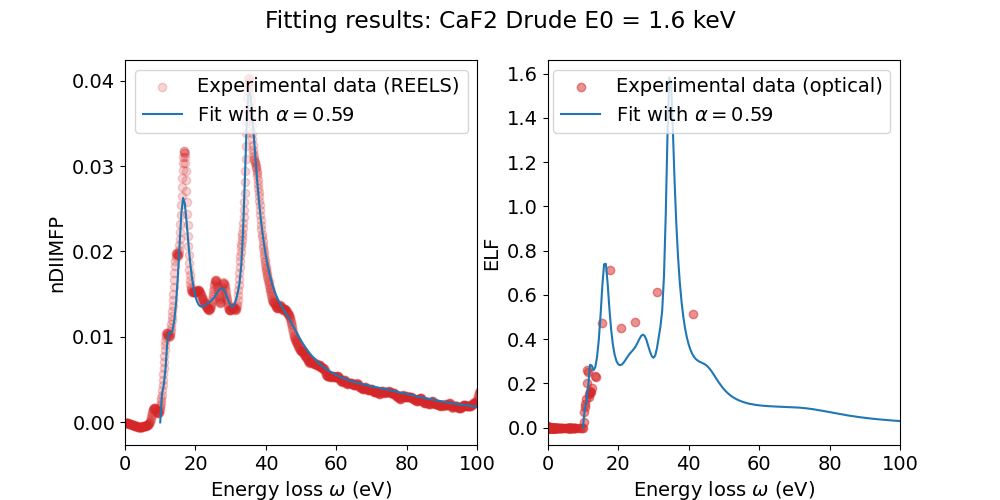

In [41]:
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/caf2/caf2.pal.csv')
exp_eps1 = fd[:,1]**2 - fd[:,2]**2
exp_eps2 = 2 * fd[:,1] * fd[:,2]

start_ind = 20
ind = np.argsort(fd[:,0])
x_exp = fd[ind,0]
y_exp = exp_eps2[ind] / (exp_eps1[ind]**2 + exp_eps2[ind]**2)

x_exp_elf = x_exp[start_ind:]
y_exp_elf = y_exp[start_ind:]

fd = pd.read_csv('../diimfp/caf2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

diimfp_coef = 1
elf_coef = 0
E0 = 1600

opt_ = opt.OptFit(caf2_drude, exp_data, E0, n_q = 8)
result = opt_.run_optimisation(diimfp_coef, elf_coef, maxeval = 10000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2struct(result)

fsum = oscOptimised.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')

plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)

In [42]:
plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

## HfO2

In [36]:
# Good fit to Vienna 1600 eV
A = [55.468, 202.308, 73.321, 12.38, 70.423, 82.37, 51.969, 89.719, 19.834, 51.402, 55.016, 109.424, 90.519]
gamma = [10.631, 23.454, 5.403, 2.415, 6.179, 11.654, 16.731, 4.314, 89.673, 12.591, 5.069, 15.468, 10.445]
omega = [18.248, 66.272, 112.084, 10.143, 43.069, 27.058, 80.4, 12.917, 65.293, 22.411, 35.06, 92.718, 46.334]
alpha = 0.877000465075102

# Good fit to Vos 5000 eV
# A =     [62.073, 270.494, 51.234, 31.765, 88.07, 71.903, 54.268, 52.249, 25.368, 119.707, 76.258, 36.77]
# gamma = [21.878, 37.443, 3.192, 4.211, 6.278, 9.837, 4.504, 3.016, 11.969, 9.974, 10.455, 6.364]
# omega = [15.707, 68.743, 9.648, 11.781, 43.964, 25.726, 9.099, 12.538, 11.46, 20.388, 39.087, 35.001]
# alpha = 0.998

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(1e-5,80,1)
q = 0

hfo2_drude = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude.e_gap = 5.6
hfo2_drude.width_of_the_valence_band = 6.5
hfo2_drude.atomic_density = rho * opt.avogadro / M *1e-24
hfo2_drude.static_refractive_index = 1.89 # from Vos paper (hafnia)
hfo2_drude.Z = Z_av
hfo2_drude.use_henke_for_ne = True

fsum = hfo2_drude.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude.Z))

kksum = hfo2_drude.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

FSum = 27.01405573684125
Z = 29.333333333333332
KKSum = 0.8845896282067365


Starting optimisation...


100%|██████████| 5000/5000 [01:44<00:00, 47.82it/s]


found minimum after 5000 evaluations
minimum value =  0.0072634253504312365
result code =  5
FSum = 27.86327110489204
Z = 29.333333333333332
KKSum = 1.0211709543877936
A = [85.014, 417.152, 59.789, 21.954, 36.546, 49.854, 51.184, 45.416, 15.531, 102.649, 46.167, 32.934]
gamma = [13.266, 52.243, 3.432, 2.263, 3.763, 9.817, 2.646, 3.037, 9.069, 13.575, 7.572, 5.757]
omega = [18.312, 49.2, 10.481, 13.11, 44.302, 22.871, 8.628, 12.17, 13.224, 22.119, 35.935, 41.436]
alpha = 0.9980968503067582


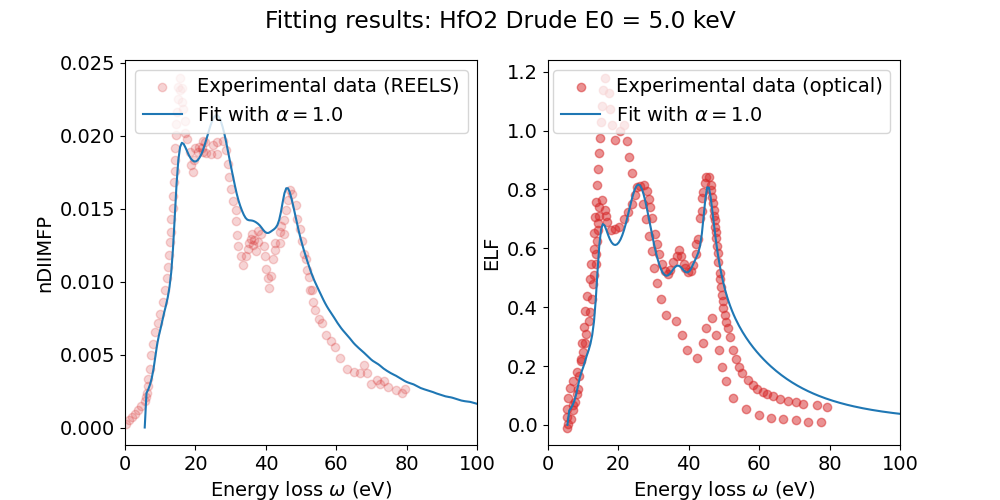

In [34]:
fd_behar = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_behar.csv', delimiter=',')
fd_jin = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_jin.csv', delimiter=',')

x_exp_elf = np.concatenate((fd_behar[:,0], fd_jin[:,0]))
y_exp_elf = np.concatenate((fd_behar[:,1], fd_jin[:,1]))

# fd = np.loadtxt('../diimfp/hfo2_diimfp.dat')
# x_exp_ndiimfp = fd[:,0]
# y_exp_ndiimfp = fd[:,1]
# E0 = 1600

fd = np.loadtxt('hfo2/ndiimfp_vos_5.csv', delimiter=',')
x_exp_ndiimfp = fd[:,0]
y_exp_ndiimfp = fd[:,1]
E0 = 5000

# fd = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
# x_exp_ndiimfp = fd[:,0]
# y_exp_ndiimfp = fd[:,1]
# E0 = 40000

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

diimfp_coef = 0.97
elf_coef = 0.03

opt_ = opt.OptFit(hfo2_drude, exp_data, E0, n_q = 8)
result = opt_.run_optimisation(diimfp_coef, elf_coef, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2struct(result)

fsum = oscOptimised.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')

plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)
# plot_fit_results(hfo2_drude, diimfp_coef, elf_coef, E0, exp_data)

# plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

In [32]:
print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')

A = [62.073, 294.494, 51.234, 31.765, 88.07, 71.903, 54.268, 52.249, 25.368, 119.707, 76.258, 36.77]
gamma = [21.878, 37.443, 3.192, 4.211, 6.278, 9.837, 4.504, 3.016, 11.969, 9.974, 10.455, 6.364]
omega = [15.707, 68.743, 9.648, 11.781, 43.964, 25.726, 9.099, 12.538, 11.46, 20.388, 39.087, 35.001]
alpha = 0.9984592759902777


In [9]:
plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

In [37]:
hfo2_vienna_1600 = hfo2_drude
# hfo2_vienna_5000 = hfo2_drude

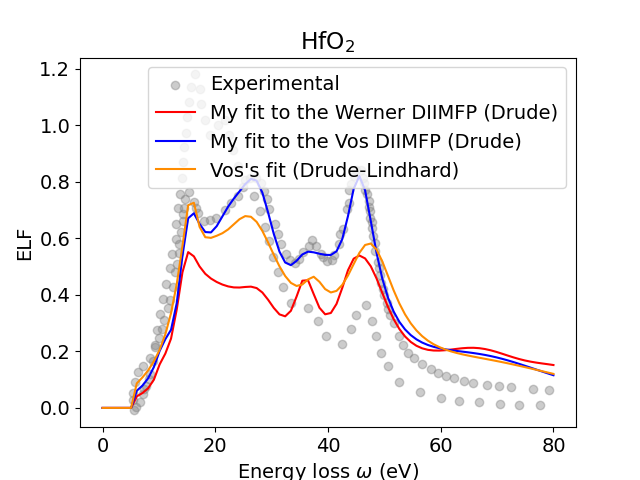

In [55]:
hfo2_vienna_1600.calculate_elf()
hfo2_vienna_5000.calculate_elf()
hfo2_dl.calculate_elf()

plt.figure()
plt.scatter(x_exp_elf,y_exp_elf,label="Experimental",color="gray",alpha=0.4)
plt.plot(hfo2_vienna_1600.eloss,hfo2_vienna_1600.elf,label="My fit to the Werner DIIMFP (Drude)",color="red")
plt.plot(hfo2_vienna_5000.eloss,hfo2_vienna_5000.elf,label="My fit to the Vos DIIMFP (Drude)",color="blue")
plt.plot(hfo2_dl.eloss, hfo2_dl.elf,label="Vos's fit (Drude-Lindhard)",color="darkorange")

plt.xlabel(r"Energy loss $\omega$ (eV)")
plt.ylabel("ELF")
plt.title(r"HfO$_2$")
plt.legend()
plt.show()

In [56]:
plt.savefig(f'{oscOptimised.name}_elf_comparison.png', dpi=600)

Data from Vos

In [39]:
A = [0.039, 0.055, 0.308, 0.113, 0.019, 0.104, 0.08]
gamma = [2.923, 7.831, 15.227, 6.435, 5.291, 11.287, 46.622]
omega = [15.715, 19.936, 27.217, 15.391, 37.559, 47.775, 71.664]
alpha = 0.1

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(1e-5,80,1)
q = 0

hfo2_dl = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_dl.e_gap = 5.6
hfo2_dl.width_of_the_valence_band = 6.5
hfo2_dl.atomic_density = rho * opt.avogadro / M *1e-24
hfo2_dl.static_refractive_index = 1.89
# hfo2_drude.electron_density = 0.305
hfo2_dl.Z = Z_av
hfo2_dl.use_henke_for_ne = True
hfo2_dl.use_kk_constraint = True
hfo2_dl.use_kk_relation = False

fsum = hfo2_dl.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_dl.Z))

kksum = hfo2_dl.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

FSum = 27.56206930909319
Z = 29.333333333333332
KKSum = 0.9698071789246108


Starting optimisation...


 89%|████████▉ | 894/1000 [21:59<02:36,  1.48s/it]


found minimum after 894 evaluations
minimum value =  0.031359939150368964
result code =  4
FSum = 26.961855291962845
Z = 29.333333333333332
KKSum = 0.9719465513236527
A = [0.083, 0.09, 0.254, 0.099, 0.033, 0.091, 0.07]
gamma = [3.018, 8.572, 15.571, 6.081, 9.352, 9.612, 69.596]
omega = [15.117, 25.245, 26.387, 16.94, 42.702, 45.969, 78.563]
alpha = 0.11480978596851805


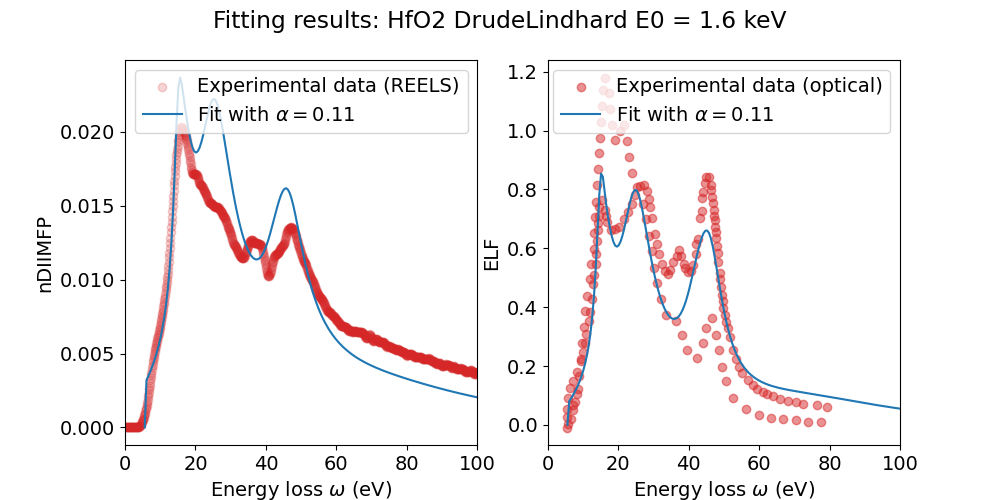

In [6]:
fd_behar = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_behar.csv', delimiter=',')
fd_jin = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_jin.csv', delimiter=',')

x_exp_elf = np.concatenate((fd_behar[:,0], fd_jin[:,0]))
y_exp_elf = np.concatenate((fd_behar[:,1], fd_jin[:,1]))

fd = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp_ndiimfp = fd[:,0]
y_exp_ndiimfp = fd[:,1]
E0 = 1600

# fd = np.loadtxt('hfo2/ndiimfp_vos_5.csv', delimiter=',')
# x_exp_ndiimfp = fd[:,0]
# y_exp_ndiimfp = fd[:,1]
# E0 = 5000

# fd = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
# x_exp_ndiimfp = fd[:,0]
# y_exp_ndiimfp = fd[:,1]
# E0 = 40000

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

diimfp_coef = 0.8
elf_coef = 0.2

opt_ = opt.OptFit(hfo2_dl, exp_data, E0, n_q = 7)
result = opt_.run_optimisation(diimfp_coef, elf_coef, maxeval = 1000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2struct(result)

fsum = oscOptimised.evaluate_f_sum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluate_kk_sum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')

plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)

In [10]:
plt.savefig(f'{oscOptimised.name}_{oscOptimised.oscillators.model}_fit.png', dpi=600)

In [15]:
A = [0.038, 0.051, 0.318, 0.109, 0.018, 0.108, 0.079]
gamma = [2.841, 7.377, 14.661, 6.338, 4.901, 10.504, 48.389]
omega = [15.84, 19.687, 27.307, 15.697, 37.701, 47.883, 71.072]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = 0.1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,80,2)
q = 0

hfo2_drude_vos_40 = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_vos_40.Eg = 5.6
hfo2_drude_vos_40.width_of_the_valence_band = 6.5
hfo2_drude_vos_40.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_vos_40.static_refractive_index = 1.89
hfo2_drude_vos_40.Z = Z_av
hfo2_drude_vos_40.use_henke_for_ne = True
hfo2_drude_vos_40.use_KK_constraint = True
hfo2_drude_vos_40.use_kk_relation = False

fsum = hfo2_drude_vos_40.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_vos_40.Z))

kksum = hfo2_drude_vos_40.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 27.63315716089351
Z = 29.333333333333332
KKSum = 0.9802969303835014


In [ ]:
exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

opt_ = opt.OptFit(hfo2_drude_vos_40, x_exp, y_exp, 40000)
result = opt_.runOptimisation('ndiimfp', maxeval = 100, xtol_rel = 1e-20)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')

print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised.calculateDIIMFP(opt_.E0)

plt.figure()
plt.plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name} {oscOptimised.oscillators.model}')
plt.legend()
plt.xlim(0,80)
plt.show()

Start optimisation
Electron density = 0.6992264162947474


In [16]:
A = [0.039, 0.156, 0.228, 0.182, 0.0176, 0.0143, 0.0077, 0.101, 0.0442]
gamma = [4.5, 3.5, 10, 8, 2.8, 2, 2.4, 7, 35]
omega = [10, 15.6, 21.5, 27.7, 35.7, 38.2, 42.5, 47.3, 58]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = 0.1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,80,0.1)
q = 0

hfo2_drude_vos = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_vos.Eg = 5.6
hfo2_drude_vos.width_of_the_valence_band = 6.5
hfo2_drude_vos.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_vos.static_refractive_index = 1.89
hfo2_drude_vos.Z = Z_av
hfo2_drude_vos.use_henke_for_ne = True
hfo2_drude_vos.use_KK_constraint = True
hfo2_drude_vos.use_kk_relation = False

fsum = hfo2_drude_vos.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_vos.Z))

kksum = hfo2_drude_vos.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 26.888136254097642
Z = 29.333333333333332
KKSum = 1.0500774477323873


<IPython.core.display.Javascript object>


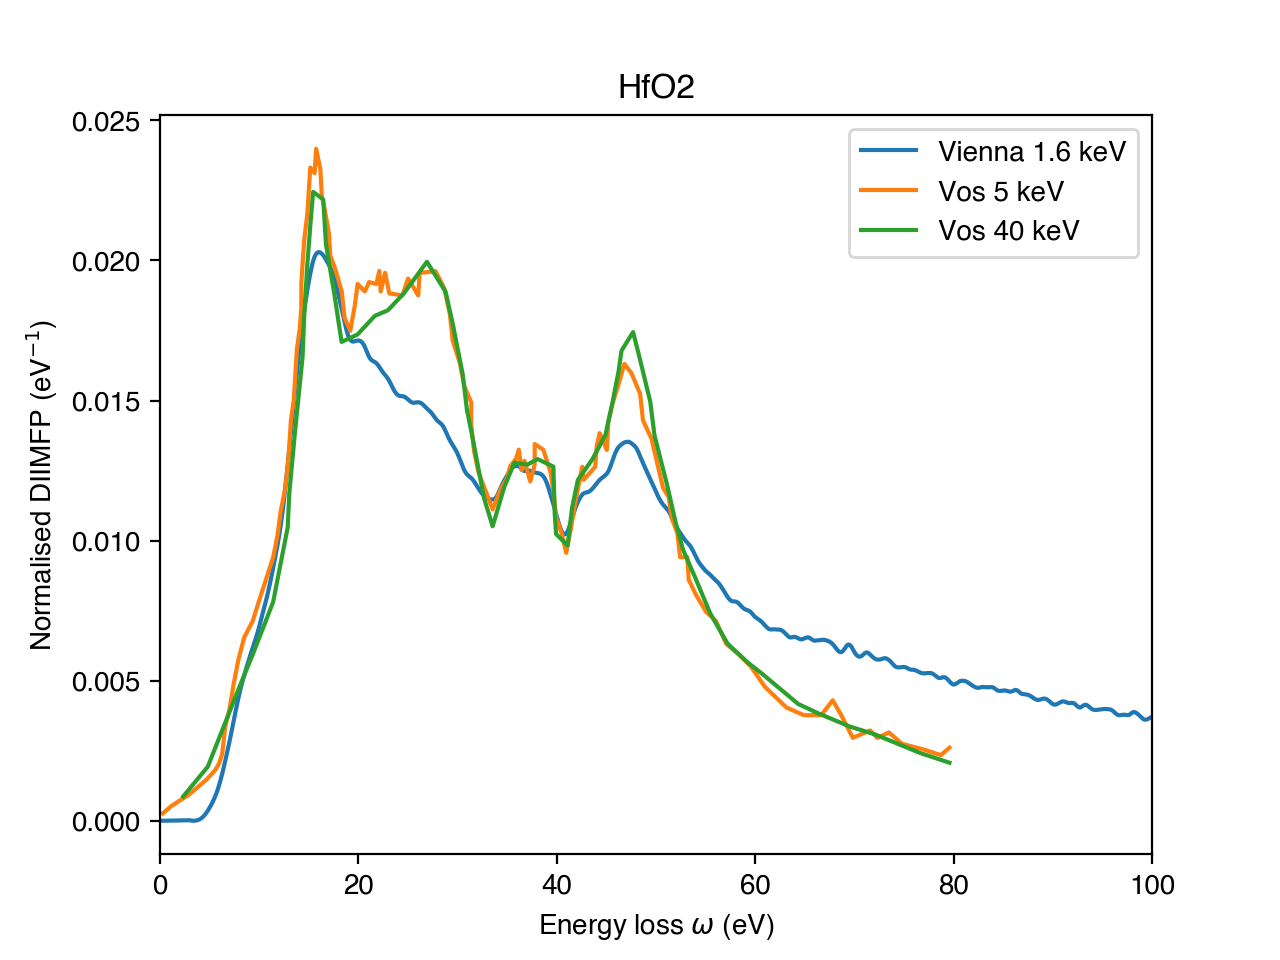

In [84]:
exp_diimfp = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
x_exp_40 = exp_diimfp[:,0]
y_exp_40 = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_5.csv', delimiter=',')
x_exp_5 = exp_diimfp[:,0]
y_exp_5 = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_jin_500_ev.csv', delimiter=',')
x_exp_jin = exp_diimfp[:,0]
y_exp_jin = exp_diimfp[:,1]

plt.figure()
# plt.plot(x_exp_jin,y_exp_jin,label='Jin 500 eV')
plt.plot(x_exp,y_exp,label='Vienna 1.6 keV')
plt.plot(x_exp_5,y_exp_5,label='Vos 5 keV')
plt.plot(x_exp_40,y_exp_40,label='Vos 40 keV')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name}')
plt.legend()
plt.xlim(0,100)
plt.show()

<IPython.core.display.Javascript object>


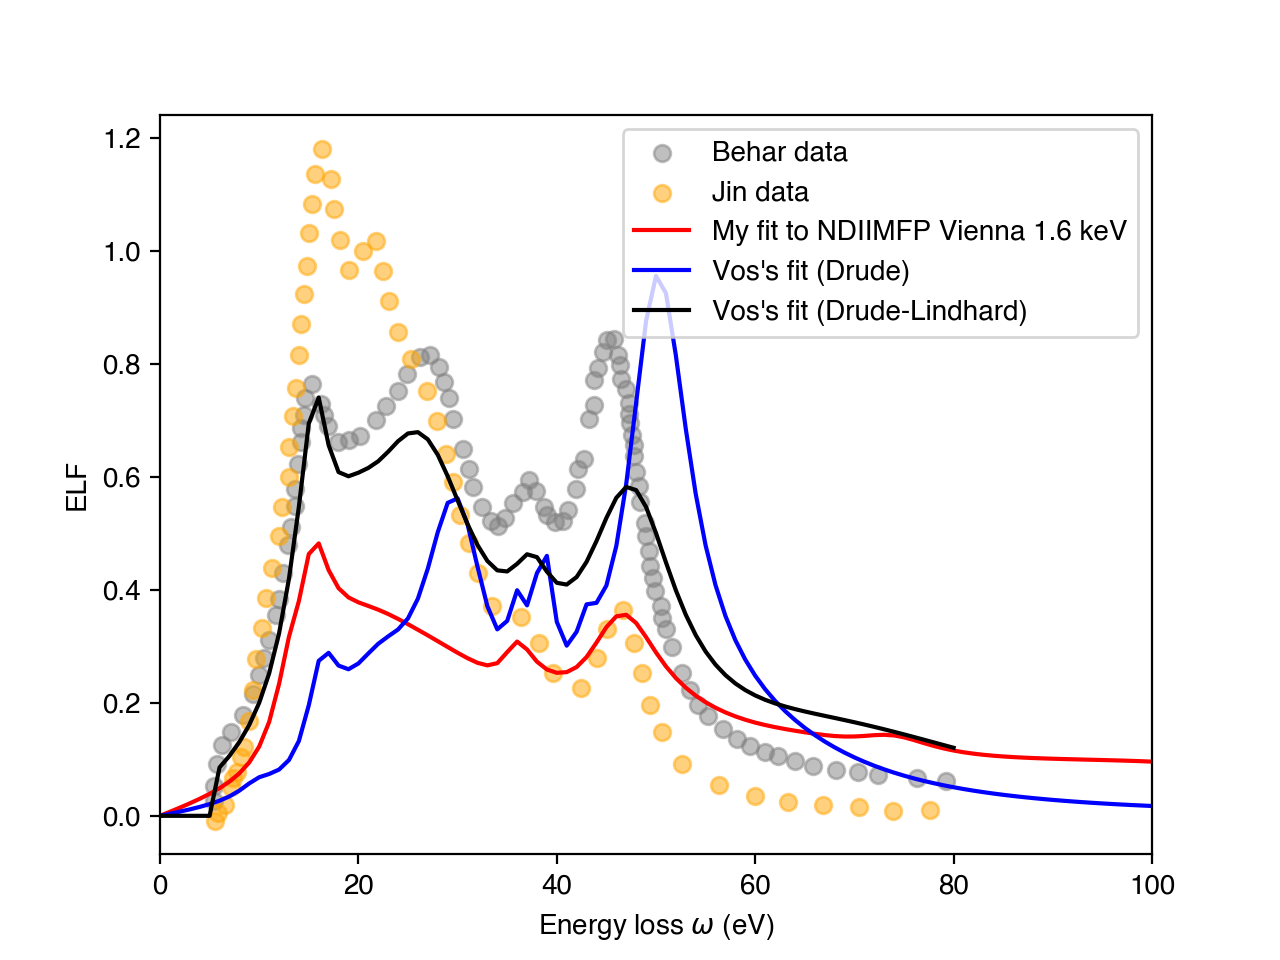

In [26]:
exp_elf_behar = np.loadtxt('hfo2/elf_behar.csv',delimiter=',')
x_exp_elf_behar = exp_elf_behar[:,0]
y_exp_elf_behar = exp_elf_behar[:,1]

exp_elf_jin = np.loadtxt('hfo2/elf_jin.csv',delimiter=',')
x_exp_elf_jin = exp_elf_jin[:,0]
y_exp_elf_jin = exp_elf_jin[:,1]

hfo2_drude.calculateELF()
hfo2_dl.calculateELF()
# hfo2_drude_vos_5.calculateELF()
# hfo2_drude_vos_40.calculateELF()

plt.figure()

plt.scatter(x_exp_elf_behar, y_exp_elf_behar, color='gray', alpha=0.5, label='Behar data')
plt.scatter(x_exp_elf_jin, y_exp_elf_jin, color='orange', alpha=0.5, label='Jin data')

plt.plot(oscOptimised.eloss, oscOptimised.ELF, label='My fit to NDIIMFP Vienna 1.6 keV', color='Red')
# plt.plot(hfo2_drude_vos_5.eloss, hfo2_drude_vos_5.ELF, label=r'My fit to NDIIMFP Vos 5 keV', color='Red')
# plt.plot(hfo2_drude_vos_40.eloss, hfo2_drude_vos_40.ELF, label=r'My fit to NDIIMFP Vos 40 keV', color='green')
plt.plot(hfo2_drude.eloss, hfo2_drude.ELF, label="Vos's fit (Drude)", color='Blue')
plt.plot(hfo2_dl.eloss, hfo2_dl.ELF, label="Vos's fit (Drude-Lindhard)", color='black')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
# plt.title(hfo2_drude.name + ' ' + hfo2_drude.model + r' $\alpha$ = 0.1')
plt.legend()
plt.xlim(0,100)
plt.show()

plt.savefig("hfo2/hfo2_elfs.png", dpi=600)

In [44]:
A = [22.599, 18.058, 10.548, 36.653, 35.798, 1.351, 31.667, 22.231, 0.002, 0.009, 45.313, 93.291, 90.353, 195.063, 10.668, 60.559, 88.983, 81.493, 108.693, 10.821]
gamma = [6.626, 17.811, 2.914, 7.625, 14.953, 19.729, 25.108, 8.661, 10.83, 17.639, 4.571, 25.609, 15.945, 74.365, 3.803, 35.944, 99.982, 27.938, 51.0, 24.123]
omega = [44.112, 51.857, 15.289, 47.34, 57.502, 63.12, 37.36, 69.618, 86.313, 66.068, 13.066, 29.5, 20.66, 89.118, 36.421, 43.162, 22.868, 90.492, 84.574, 30.638]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = 1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

hfo2_drude_alpha_1 = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_alpha_1.Eg = 5.6
hfo2_drude_alpha_1.width_of_the_valence_band = 6.5
hfo2_drude_alpha_1.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_alpha_1.static_refractive_index = 1.89
# hfo2_drude_alpha_1.electron_density = 0.305
hfo2_drude_alpha_1.Z = Z_av
hfo2_drude_alpha_1.use_henke_for_ne = True
hfo2_drude_alpha_1.use_KK_constraint = True
hfo2_drude_alpha_1.use_kk_relation = False

fsum = hfo2_drude_alpha_1.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_alpha_1.Z))

kksum = hfo2_drude_alpha_1.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 26.28797779993503
Z = 29.333333333333332
KKSum = 0.7388764414789972


Start optimisation
Electron density = 0.6992264162947474
FSum = 26.397231154622325
Z = 29.333333333333332
KKSum = 0.8021650324238212
A = [22.378, 11.137, 19.464, 73.383, 29.401, 1.358, 24.008, 24.371, 0.002, 0.008, 59.889, 121.526, 89.08, 141.525, 16.334, 41.278, 58.909, 77.035, 146.734, 6.345]
gamma = [4.56, 35.992, 3.13, 9.114, 24.332, 33.329, 18.646, 12.301, 22.027, 30.76, 4.353, 24.296, 16.623, 99.36, 4.618, 74.23, 99.99, 20.899, 51.727, 16.819]
omega = [44.509, 44.56, 13.52, 44.2, 63.879, 112.88, 37.741, 68.064, 117.56, 101.785, 11.777, 28.133, 19.292, 82.69, 35.191, 40.061, 23.8, 98.722, 80.353, 30.461]
osc.A = [22.378 11.137 19.464 73.383 29.401 1.358 24.008 24.371 0.002 0.008 59.889 121.526 89.08 141.525 16.334 41.278 58.909 77.035 146.734 6.345];
osc.G = [4.56 35.992 3.13 9.114 24.332 33.329 18.646 12.301 22.027 30.76 4.353 24.296 16.623 99.36 4.618 74.23 99.99 20.899 51.727 16.819];
osc.Om = [44.509 44.56 13.52 44.2 63.879 112.88 37.741 68.064 117.56 101.785 11.777 28.133 19.

<IPython.core.display.Javascript object>


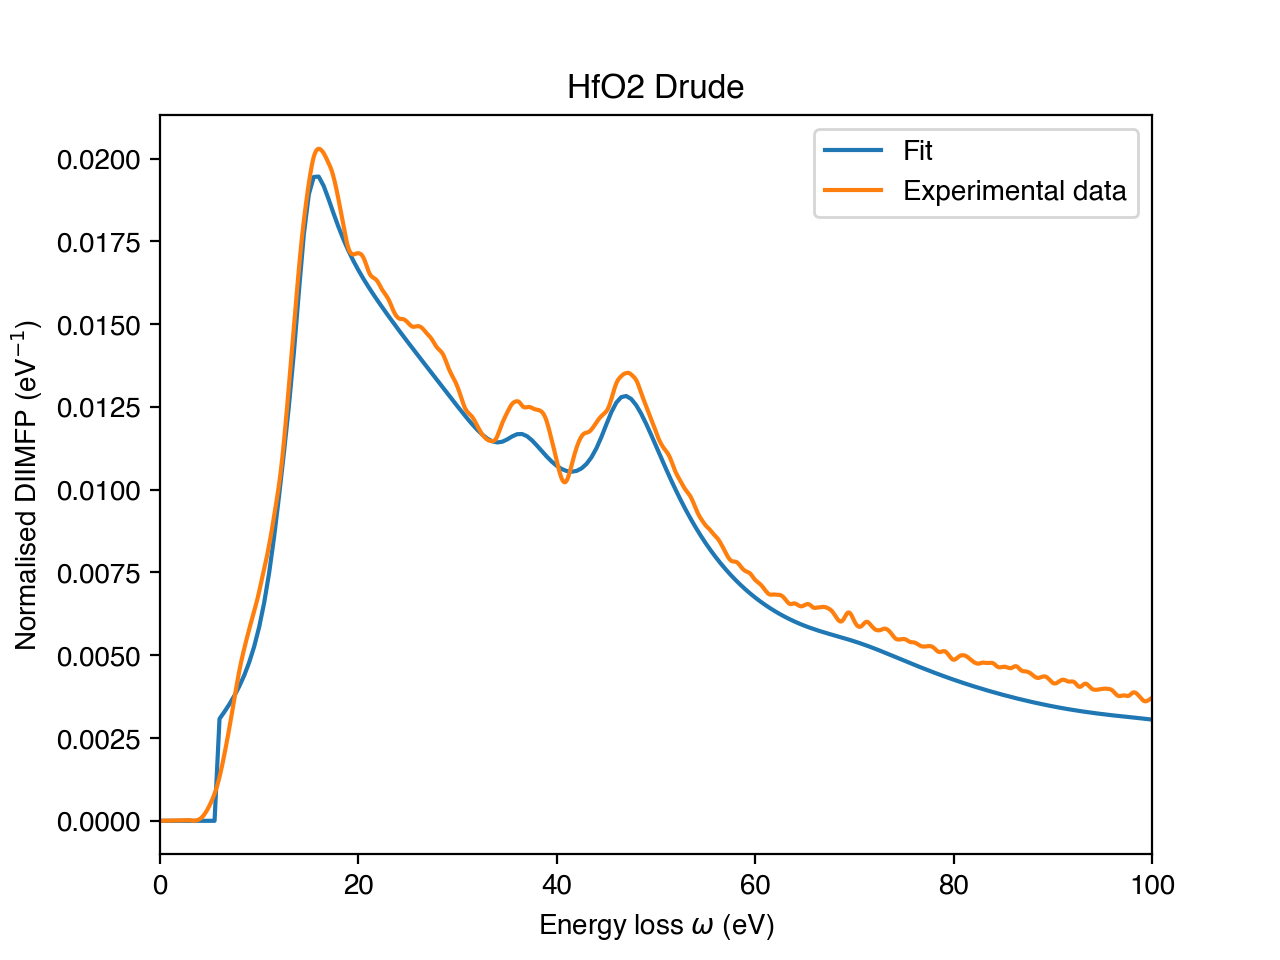

In [46]:
exp_diimfp = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

opt_ = opt.OptFit(hfo2_drude_alpha_1, x_exp, y_exp, 1600)
result = opt_.runOptimisation('ndiimfp', maxeval = 1000, xtol_rel = 1e-17)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')

print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised.calculateDIIMFP(opt_.E0)

plt.figure()
plt.plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name} {oscOptimised.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

## VN

In [48]:
A = [3.032, 26.791, 9.568, 13.428, 399.698, 554.798, 98.009, 65.269]
gamma = [10.393, 4.228, 6.898, 4.766, 9.117, 74.567, 10.238, 96.112]
omega = [3.947, 14.498, 30.844, 23.985, 3.231, 127.142, 20.17, 96.563]
alpha = 0.982

M = (1 * 50.9415 + 1 * 14.007) / (1 + 1) # Molar weight
Z_av = (1 * 23 + 1 * 7) / (1 + 1)
rho = 6.13 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['v','n'], [1,1])
eloss = opt.linspace(0,100,0.1)
q = 0

vn_drude = opt.Material('vn', oscillators, composition, eloss, q, xraypath)
vn_drude.Eg = 0
vn_drude.width_of_the_valence_band = 0
vn_drude.Ef = 12.65
vn_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
vn_drude.static_refractive_index = 4.23
vn_drude.Z = Z_av
vn_drude.use_henke_for_ne = True
vn_drude.use_KK_constraint = False
vn_drude.use_kk_relation = False

fsum = vn_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(vn_drude.Z))

kksum = vn_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 11.594345447122794
Z = 15.0
KKSum = 0.9667861431090766


Starting optimisation...
found minimum after 50000 evaluations
minimum value =  0.0004629266745848281
result code =  5
FSum = 11.59435655526187
Z = 15.0
KKSum = 0.9667832732994326
A = [3.032, 26.791, 9.568, 13.428, 399.698, 554.798, 98.009, 65.269]
gamma = [10.393, 4.228, 6.898, 4.766, 9.117, 74.567, 10.238, 96.112]
omega = [3.947, 14.498, 30.844, 23.985, 3.231, 127.142, 20.17, 96.563]
alpha = 0.9828249622363121


<IPython.core.display.Javascript object>


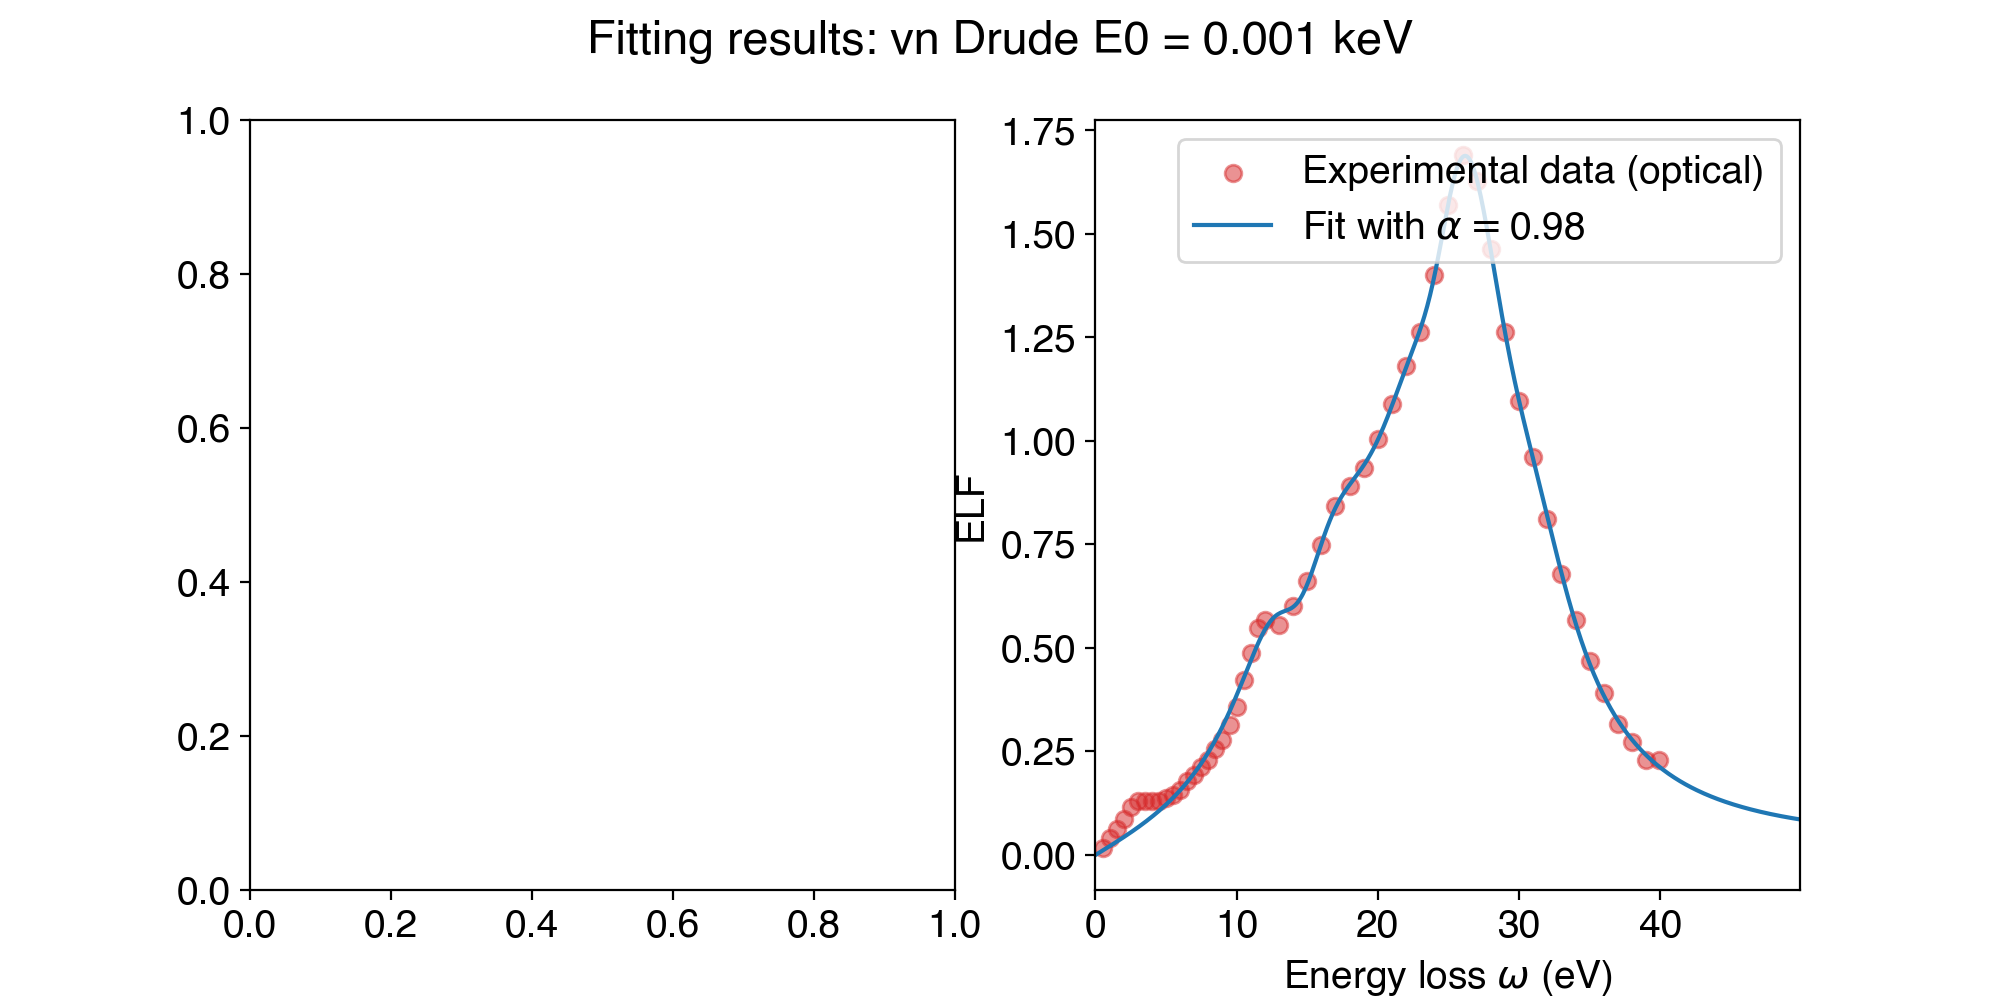

In [47]:
dt = np.loadtxt('vn.csv', delimiter=',', skiprows=1)

eps1 = dt[:,1]**2 - dt[:,2]**2
eps2 = 2*dt[:,1]*dt[:,2]

x_exp_elf = dt[:,0]
y_exp_elf = eps2/(eps1**2+eps2**2)

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
elf_coef = 1
exp_data.x_ndiimfp = np.zeros(10)
exp_data.y_ndiimfp = np.zeros(10)
diimfp_coef = 0

E0 = 1
opt_ = opt.OptFit(vn_drude, exp_data, E0, n_q = 6)
result = opt_.runOptimisation(diimfp_coef, elf_coef, maxeval = 50000, xtol_rel = 1e-6)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)

In [74]:
def wavelength2energy(wavelength):
    return opt.hc * 1e3 / (wavelength)

In [90]:
wavelength2energy(np.array([466, 522, 598, 638])*10)
eps2/(eps1**2 + eps2**2)

array([0.08184601, 0.07719304, 0.0608475 , 0.05456664])

<IPython.core.display.Javascript object>


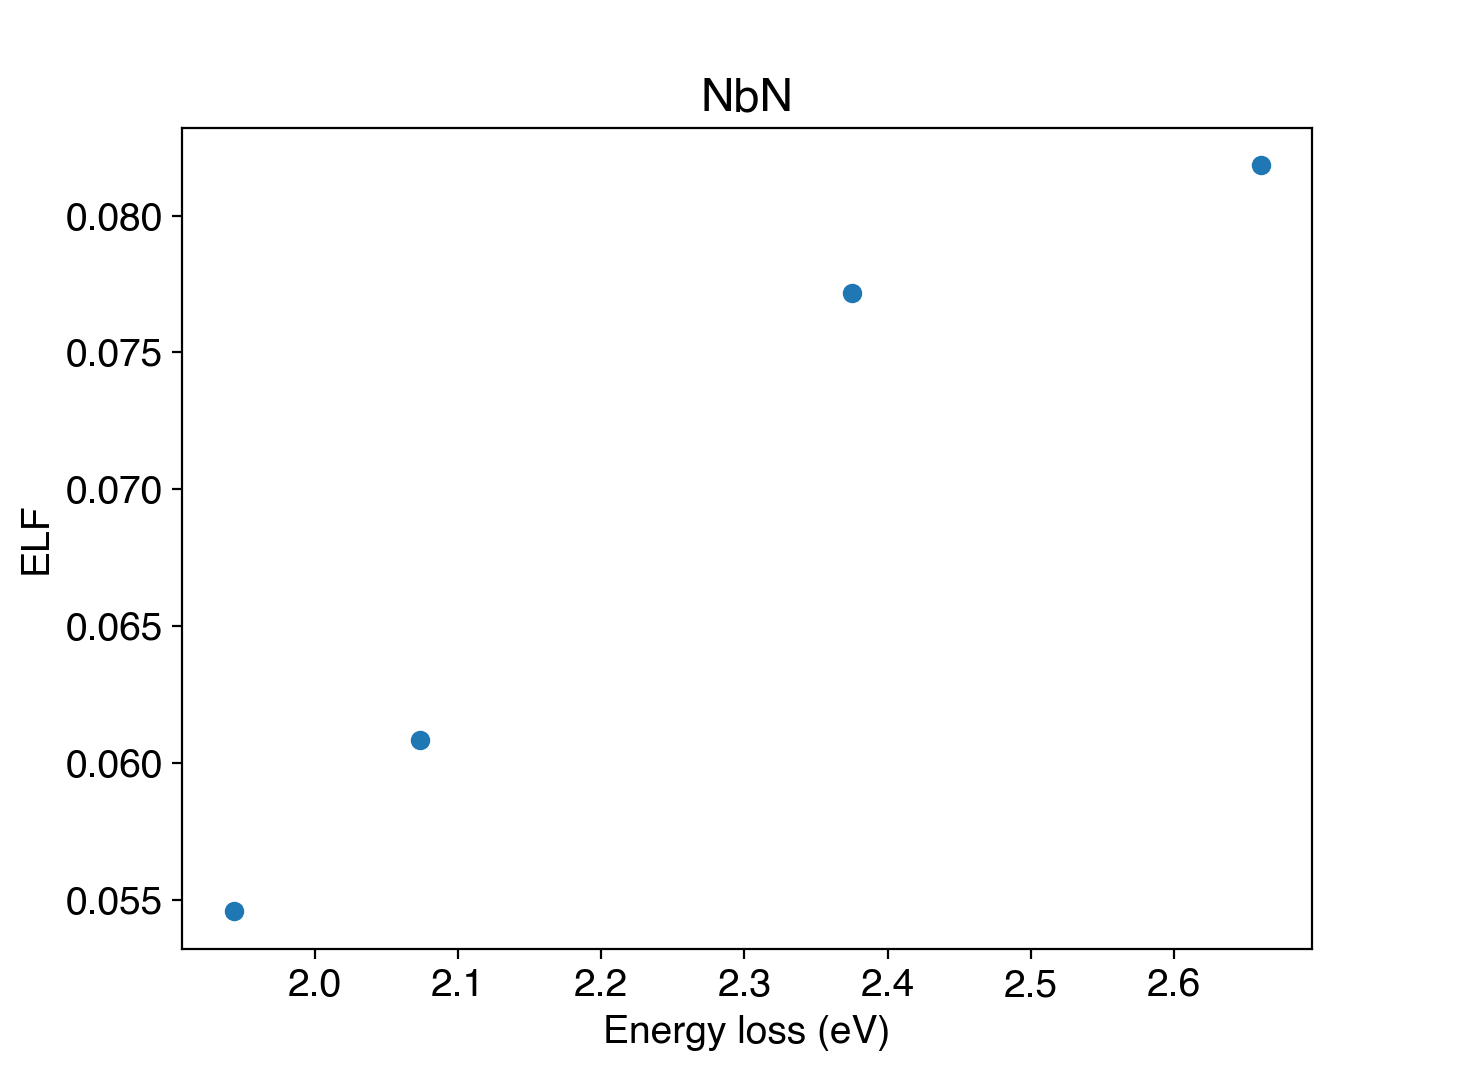

In [93]:
# https://arxiv.org/pdf/1812.05559.pdf

n = np.array([2.456, 2.554, 2.643, 2.822])
k = np.array([2.487, 2.536, 3.047, 3.197])
energy = wavelength2energy(np.array([466, 522, 598, 638])*10)
eps1 = n**2 - k**2
eps2 = 2*n*k

plt.figure()
plt.plot(energy, eps2/(eps1**2 + eps2**2),'o')
plt.xlabel('Energy loss (eV)')
plt.ylabel('ELF')
plt.title('NbN')
plt.show()

In [50]:
A = [0.003032, 0.026791, 0.009568, 0.013428, 0.399698, 0.55498, 0.098009, 0.065269]
gamma = [10.393, 4.228, 6.898, 4.766, 9.117, 74.567, 10.238, 96.112]
omega = [3.947, 14.498, 30.844, 23.985, 3.231, 127.142, 20.17, 96.563]
alpha = 0.982

M = (1 * 50.9415 + 1 * 14.007) / (1 + 1) # Molar weight
Z_av = (1 * 23 + 1 * 7) / (1 + 1)
rho = 6.13 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['v','n'], [1,1])
eloss = opt.linspace(0,100,0.1)
q = 0

vn_dl = opt.Material('vn', oscillators, composition, eloss, q, xraypath)
vn_dl.Eg = 0
vn_dl.width_of_the_valence_band = 0
vn_dl.Ef = 12.65
vn_dl.atomic_density = rho * opt.N_Avogadro / M *1e-24
vn_dl.static_refractive_index = 4.23
vn_dl.Z = Z_av
vn_dl.use_henke_for_ne = True
vn_dl.use_KK_constraint = False
vn_dl.use_kk_relation = False

fsum = vn_dl.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(vn_dl.Z))

kksum = vn_dl.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 16.22928928269685
Z = 15.0
KKSum = 0.8601153516728339


Starting optimisation...
found minimum after 5000 evaluations
minimum value =  0.008683827317266662
result code =  5
FSum = 14.51201788894259
Z = 15.0
KKSum = 1.3143360585063704
A = [0.005, 0.055, 0.024, 0.015, 0.157, 0.712, 0.292, 0.099]
gamma = [24.156, 6.044, 5.67, 5.027, 21.84, 90.888, 7.126, 96.438]
omega = [5.392, 28.582, 19.275, 19.109, 3.153, 39.844, 25.79, 121.099]
alpha = 0.9788668090036039


<IPython.core.display.Javascript object>


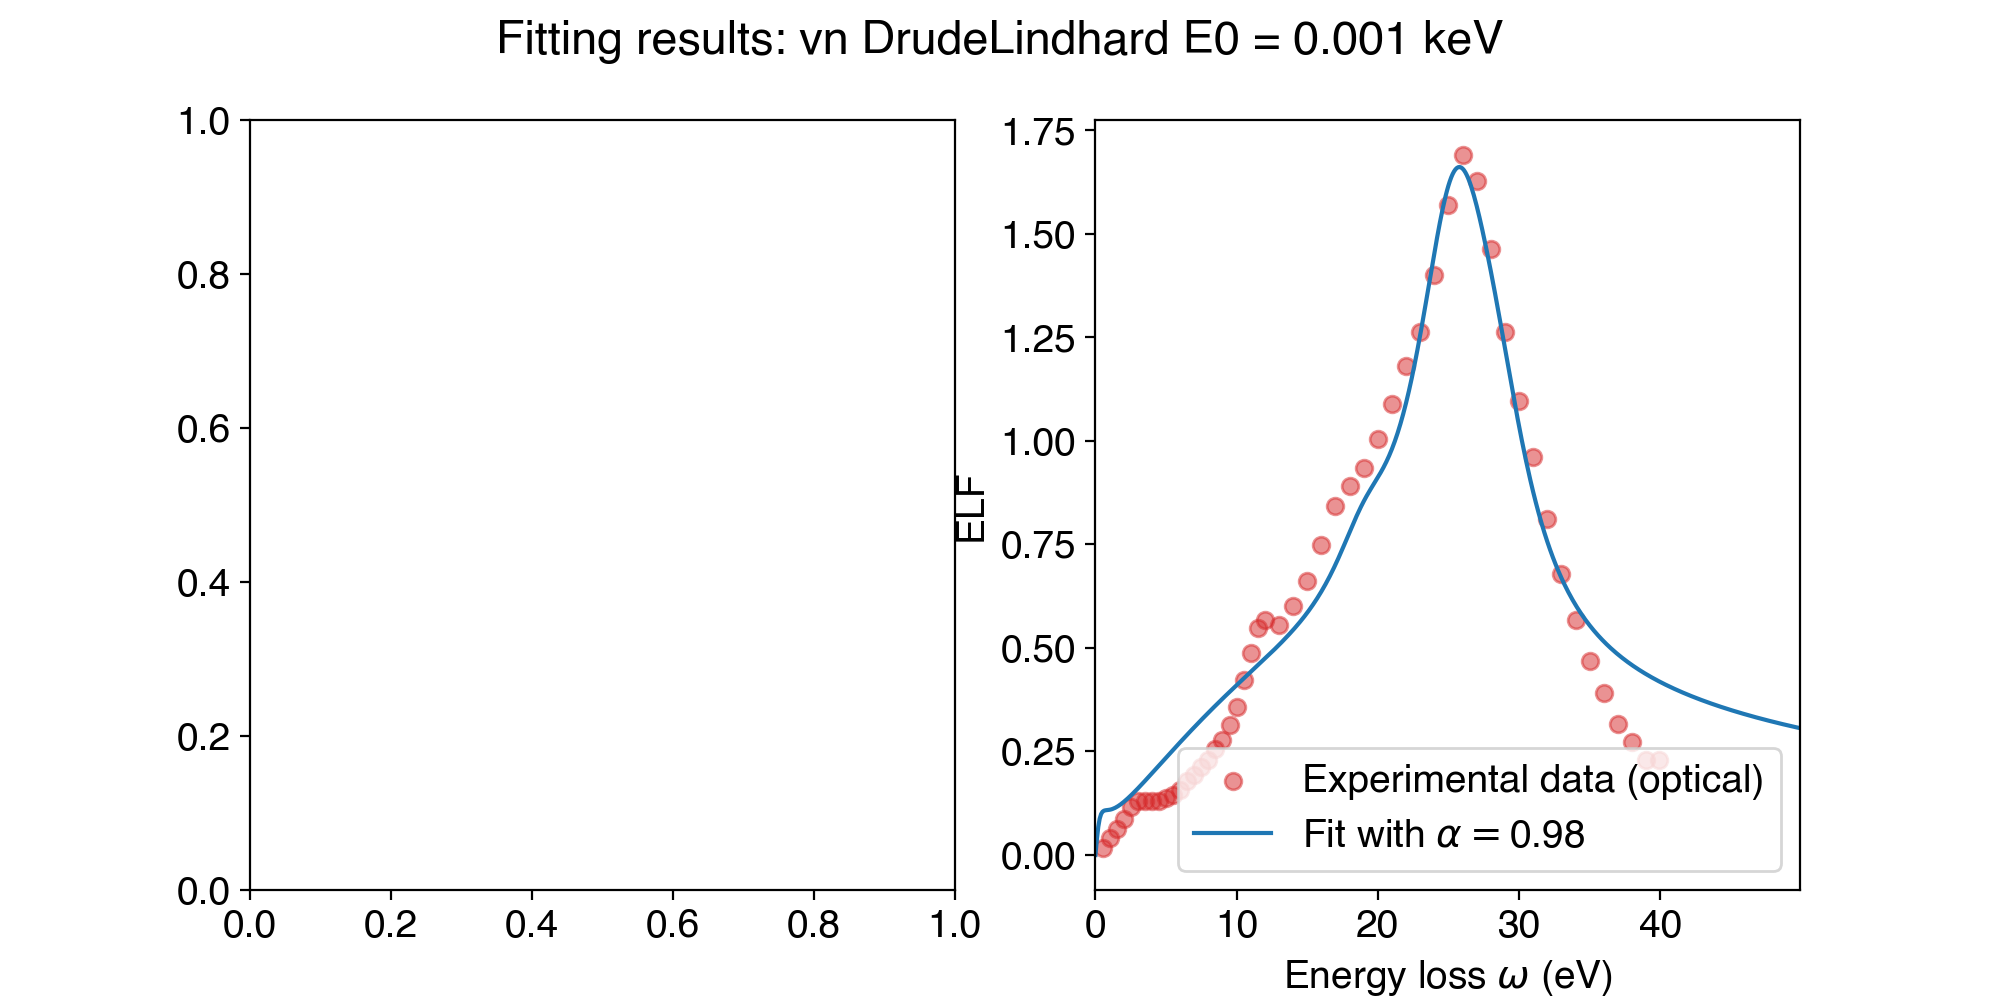

In [51]:
dt = np.loadtxt('vn.csv', delimiter=',', skiprows=1)

eps1 = dt[:,1]**2 - dt[:,2]**2
eps2 = 2*dt[:,1]*dt[:,2]

x_exp_elf = dt[:,0]
y_exp_elf = eps2/(eps1**2+eps2**2)

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
elf_coef = 1
exp_data.x_ndiimfp = np.zeros(10)
exp_data.y_ndiimfp = np.zeros(10)
diimfp_coef = 0

E0 = 1
opt_ = opt.OptFit(vn_dl, exp_data, E0, n_q = 6)
result = opt_.runOptimisation(diimfp_coef, elf_coef, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)

## TiN

<IPython.core.display.Javascript object>


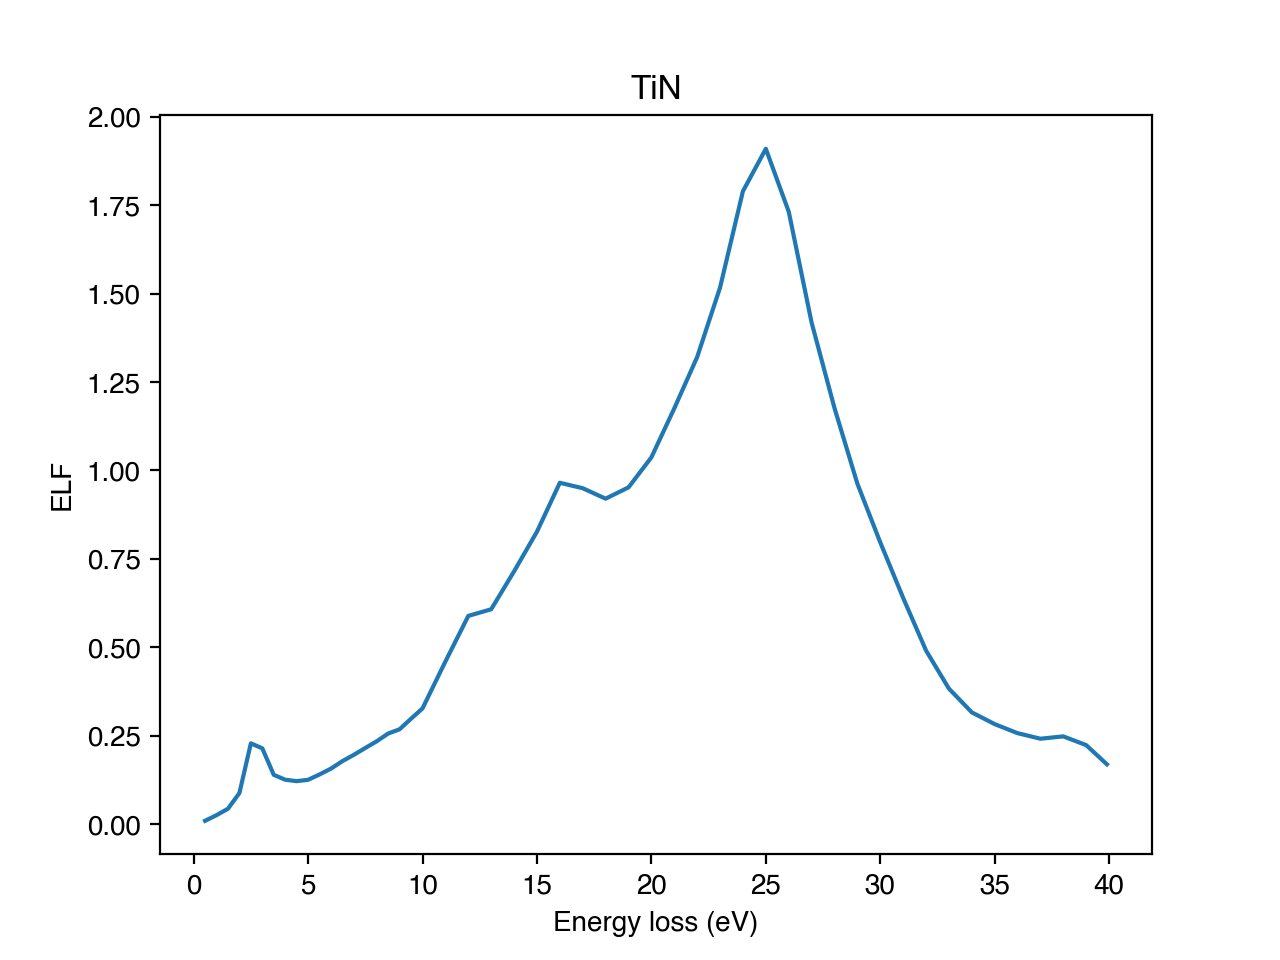

In [10]:
dt = np.loadtxt('tin.csv', delimiter=',', skiprows=1)

eps1 = dt[:,1]**2 - dt[:,2]**2
eps2 = 2*dt[:,1]*dt[:,2]

plt.figure()
plt.plot(dt[:,0], eps2/(eps1**2+eps2**2))
plt.xlabel('Energy loss (eV)')
plt.ylabel('ELF')
plt.title('TiN')
plt.show()

## SiC

In [27]:
A = [6.679, 115.494, 271.547, 92.861]
gamma = [3.13, 4.605, 4.011, 38.269]
omega = [18.465, 10.029, 6.388, 30.346]
alpha = 0.972

M = (1 * 28.085 + 1 * 12.0107) / (1 + 1) # Molar weight
Z_av = (1 * 14 + 1 * 6) / (1 + 1)
rho = 3.22 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['si','c'], [1,1])
eloss = opt.linspace(0,100,0.1)
q = 0

sic_drude = opt.Material('SiC', oscillators, composition, eloss, q, xraypath)
sic_drude.Eg = 2.31
sic_drude.width_of_the_valence_band = 6.95
sic_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
sic_drude.static_refractive_index = 2.6473
sic_drude.Z = Z_av
sic_drude.use_henke_for_ne = True # 0.305
sic_drude.use_KK_constraint = False
sic_drude.use_kk_relation = False

fsum = sic_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sic_drude.Z))

kksum = sic_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 9.561075874831998
Z = 10.0
KKSum = 1.0339072514171097


Starting optimisation...
found minimum after 50000 evaluations
minimum value =  0.00027993169042471043
result code =  5
FSum = 9.561075543706343
Z = 10.0
KKSum = 1.0339144198380157
A = [6.679, 115.494, 271.547, 92.861]
gamma = [3.13, 4.605, 4.011, 38.269]
omega = [18.465, 10.029, 6.388, 30.346]
alpha = 0.9726536462617286


<IPython.core.display.Javascript object>


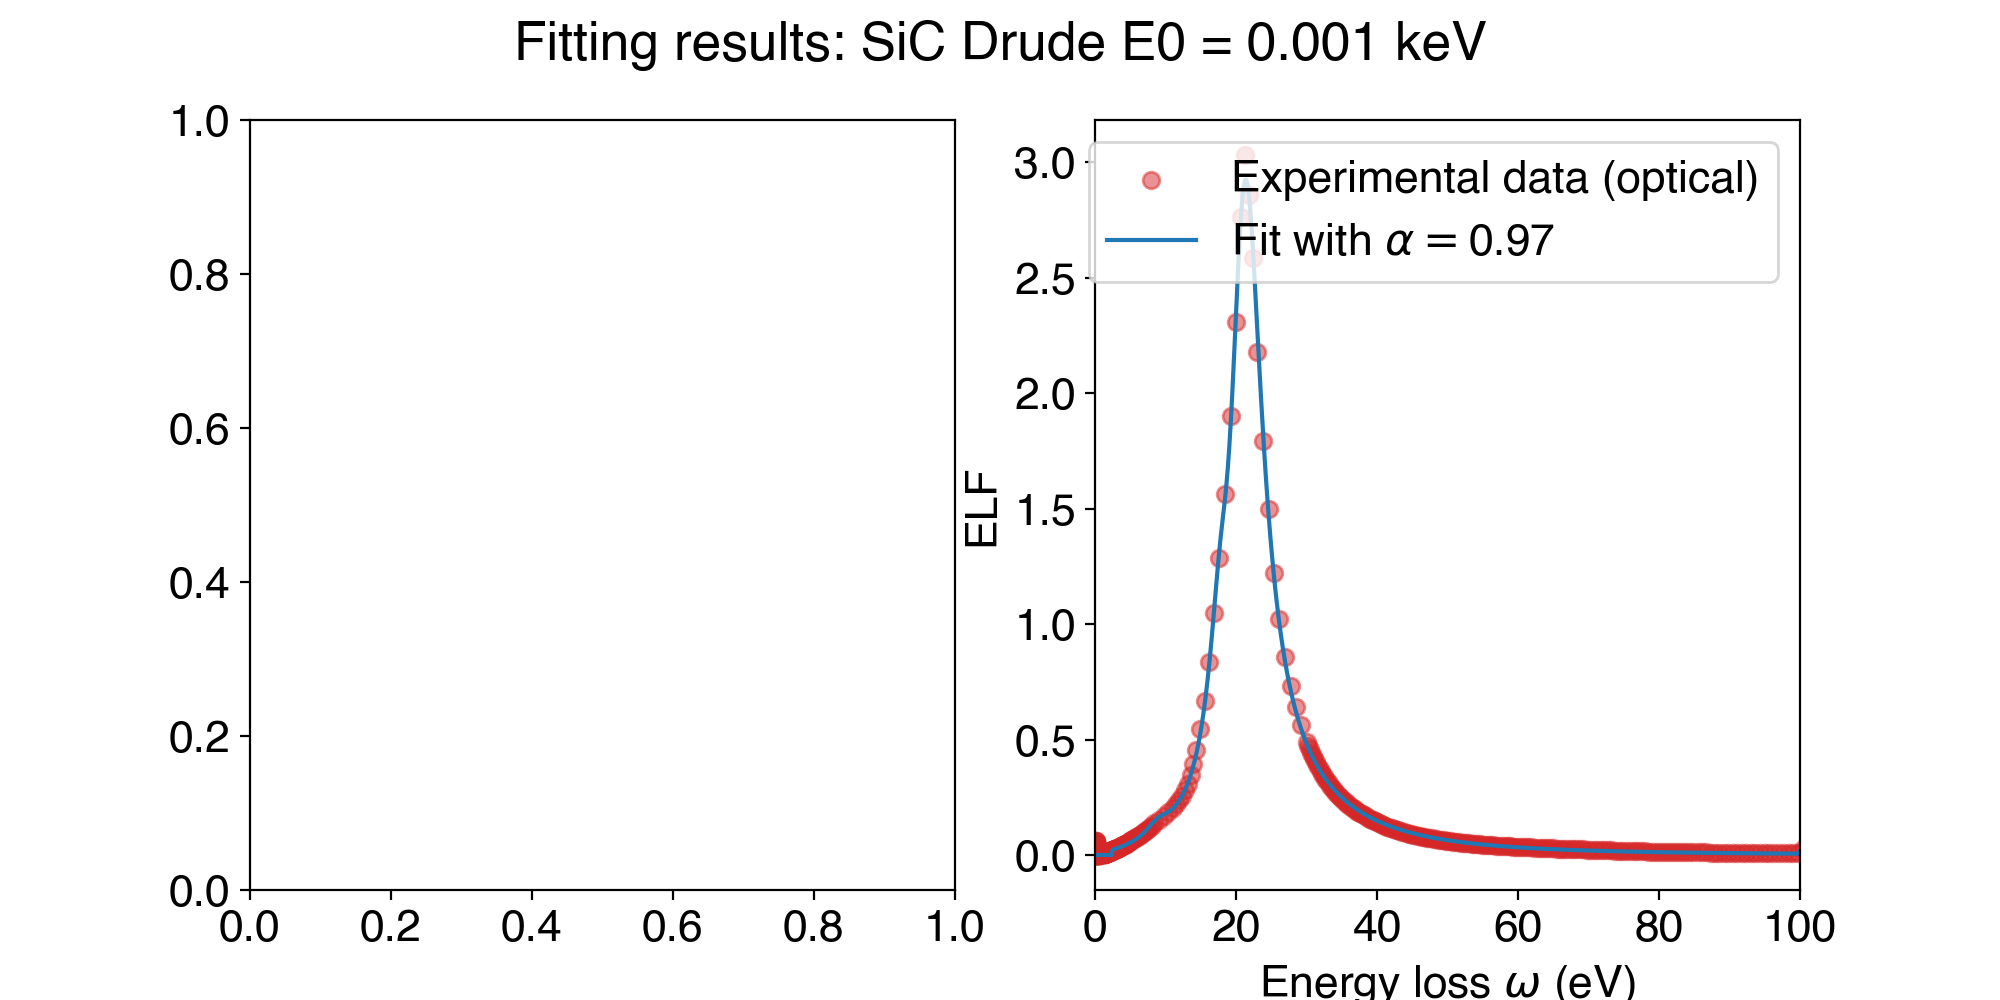

In [26]:
dt = np.loadtxt('sic.csv', delimiter=',', skiprows=1)

eps1 = dt[:,1]**2 - dt[:,2]**2
eps2 = 2*dt[:,1]*dt[:,2]

x_exp_elf = dt[:,0]
y_exp_elf = eps2/(eps1**2+eps2**2)

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
elf_coef = 1
exp_data.x_ndiimfp = np.zeros(10)
exp_data.y_ndiimfp = np.zeros(10)
diimfp_coef = 0

E0 = 1
opt_ = opt.OptFit(sic_drude, exp_data, E0, n_q = 6)
result = opt_.runOptimisation(diimfp_coef, elf_coef, maxeval = 50000, xtol_rel = 1e-6)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# plot_fit_results(sic_drude, E0, exp_data)
plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)

In [30]:
A = [0.027, 0.55, 0.132, 0.19]
gamma = [25.214, 4.86, 5.308, 13.992]
omega = [24.494, 21.656, 18.675, 27.119]
alpha = 0.949

M = (1 * 28.085 + 1 * 12.0107) / (1 + 1) # Molar weight
Z_av = (1 * 14 + 1 * 6) / (1 + 1)
rho = 3.22 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['si','c'], [1,1])
eloss = opt.linspace(0,100,0.1)
q = 0

sic_dl = opt.Material('SiC', oscillators, composition, eloss, q, xraypath)
sic_dl.Eg = 2.31
sic_dl.width_of_the_valence_band = 6.95
sic_dl.atomic_density = rho * opt.N_Avogadro / M *1e-24
sic_dl.static_refractive_index = 2.6473
sic_dl.Z = Z_av
sic_dl.use_henke_for_ne = True # 0.305
sic_dl.use_KK_constraint = True
sic_dl.use_kk_relation = False

fsum = sic_dl.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sic_dl.Z))

kksum = sic_dl.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 9.428695353453353
Z = 10.0
KKSum = 1.0396791699842582


Starting optimisation...
found minimum after 3452 evaluations
minimum value =  0.00038216623291695474
result code =  4
FSum = 9.432571753950587
Z = 10.0
KKSum = 1.040611635121543
A = [0.027, 0.55, 0.132, 0.19]
gamma = [25.214, 4.86, 5.308, 13.992]
omega = [24.494, 21.656, 18.675, 27.119]
alpha = 0.9499344022919619


<IPython.core.display.Javascript object>


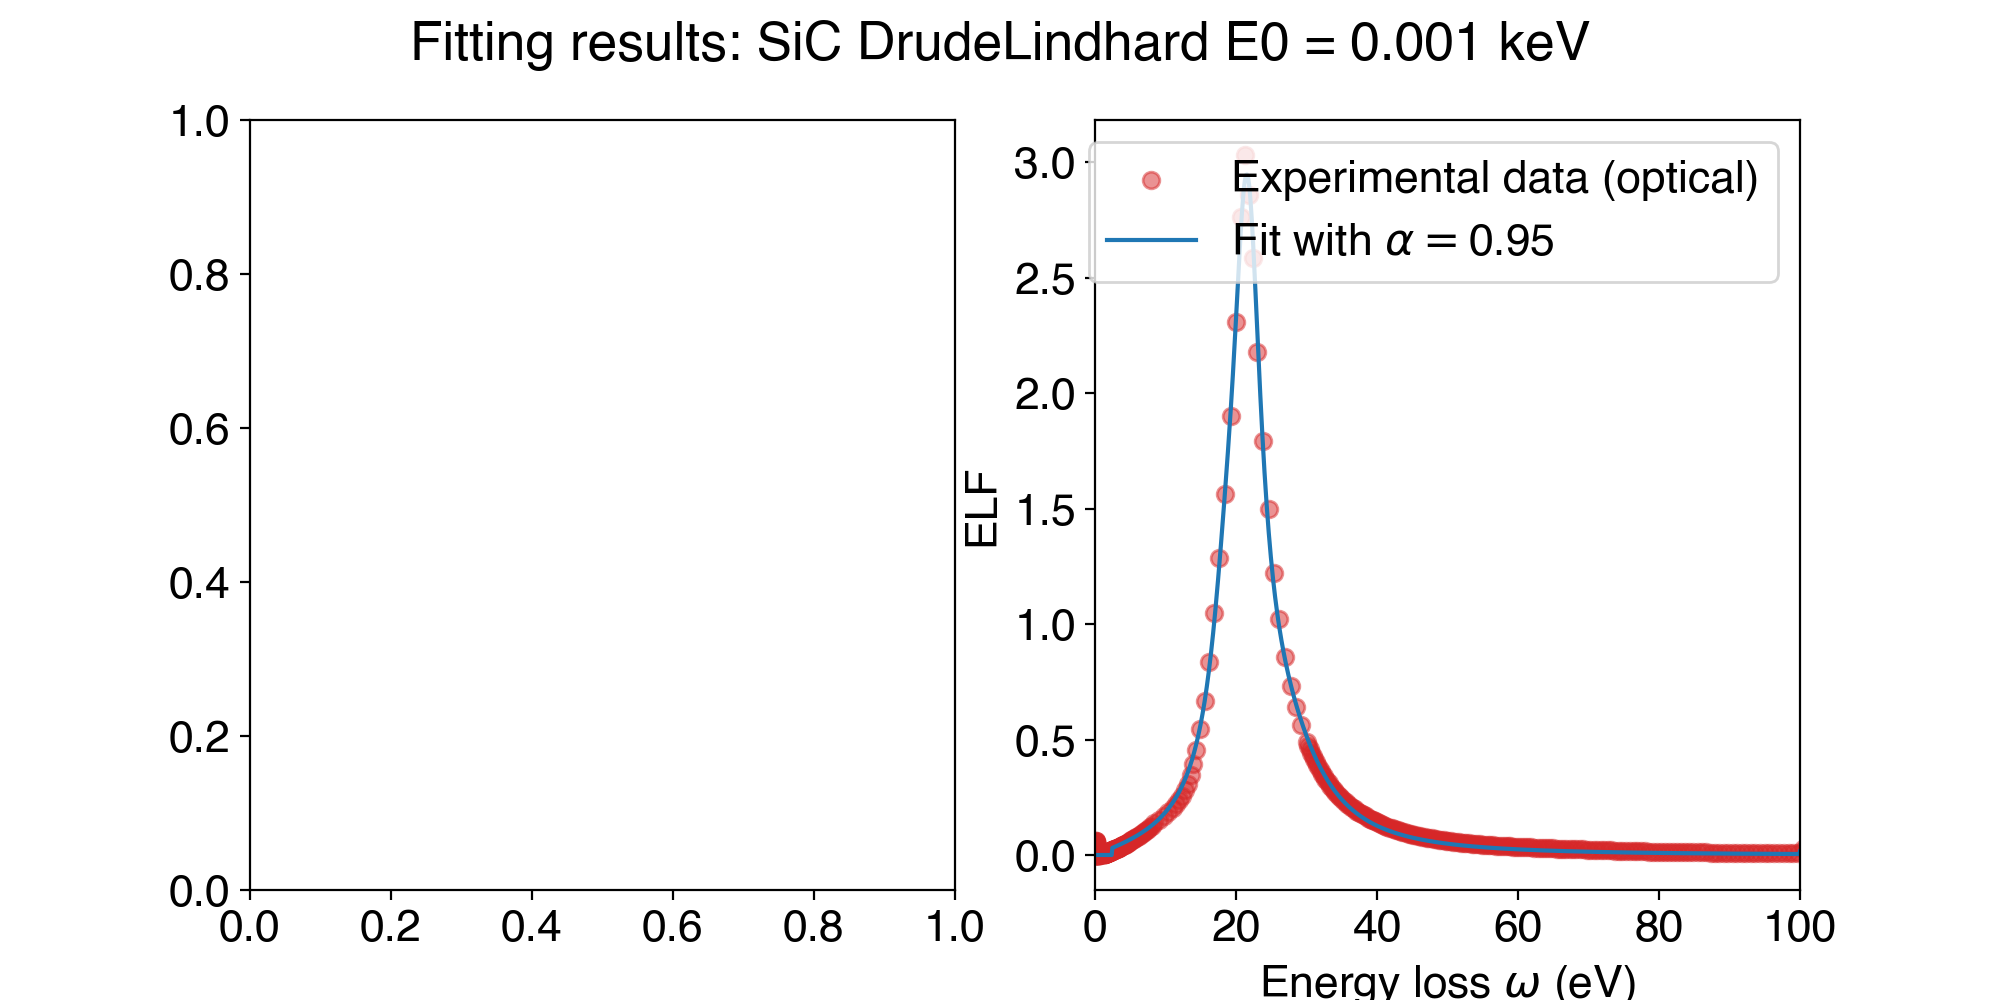

In [29]:
dt = np.loadtxt('sic.csv', delimiter=',', skiprows=1)

eps1 = dt[:,1]**2 - dt[:,2]**2
eps2 = 2*dt[:,1]*dt[:,2]

x_exp_elf = dt[:,0]
y_exp_elf = eps2/(eps1**2+eps2**2)

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
elf_coef = 1
exp_data.x_ndiimfp = np.zeros(10)
exp_data.y_ndiimfp = np.zeros(10)
diimfp_coef = 0

E0 = 1
opt_ = opt.OptFit(sic_dl, exp_data, E0, n_q = 6)
result = opt_.runOptimisation(diimfp_coef, elf_coef, maxeval = 5000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# plot_fit_results(sic_drude, E0, exp_data)
plot_fit_results(oscOptimised, diimfp_coef, elf_coef, E0, exp_data)

In [31]:
osc = oscOptimised
osc.convert_to_MLL()
sic_mll = osc
sic_mll.oscillators.model = 'MerminLL'

fsum = sic_mll.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sic_mll.Z))

kksum = sic_mll.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in sic_mll.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in sic_mll.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in sic_mll.oscillators.omega.round(3).tolist()])}]')
print(f'U = {sic_mll.U}')

currentU 1.0 UstepSize 1.0
currentU 2.0 UstepSize 1.0
currentU 3.0 UstepSize 1.0
currentU 4.0 UstepSize 1.0
currentU 5.0 UstepSize 1.0
currentU 6.0 UstepSize 1.0
currentU 7.0 UstepSize 1.0
newsumA 0.9724521883517278
currentU 6.1 UstepSize 0.1
currentU 6.199999999999999 UstepSize 0.1
currentU 6.299999999999999 UstepSize 0.1
currentU 6.399999999999999 UstepSize 0.1
currentU 6.499999999999998 UstepSize 0.1
currentU 6.599999999999998 UstepSize 0.1
currentU 6.6999999999999975 UstepSize 0.1
currentU 6.799999999999997 UstepSize 0.1
currentU 6.899999999999997 UstepSize 0.1
currentU 6.9999999999999964 UstepSize 0.1
newsumA 0.9985412155318427
FSum = 9.43282743482339
Z = 10.0
KKSum = 1.0593548089766003
A = [0.029, 0.613, 0.153, 0.204]
gamma = [25.214, 4.86, 5.308, 13.992]
omega = [23.503, 20.528, 17.353, 26.226]
U = 6.899999999999997


In [32]:
A = [0.029, 0.613, 0.153, 0.204]
gamma = [25.214, 4.86, 5.308, 13.992]
omega = [23.503, 20.528, 17.353, 26.226]
U = 6.899

M = (1 * 28.085 + 2 * 12.0107) / (1 + 1) # Molar weight
Z_av = (1 * 14 + 2 * 6) / (1 + 1)
rho = 3.22 # g/cm3

oscillators = opt.Oscillators('MerminLL', A, gamma, omega, alpha = 1)
composition = opt.Composition(['si','c'], [1,1])
eloss = opt.linspace(0,100,0.1)
q = 0

sic_mll = opt.Material('SiC', oscillators, composition, eloss, q, xraypath)
sic_mll.Eg = 2.31
sic_mll.width_of_the_valence_band = 6.95
sic_mll.atomic_density = rho * opt.N_Avogadro / M *1e-24
sic_mll.static_refractive_index = 2.6473
sic_mll.Z = Z_av
sic_mll.use_henke_for_ne = True # 0.305
sic_mll.use_KK_constraint = True
sic_mll.use_kk_relation = False
sic_mll.U = U

fsum = sic_mll.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sic_mll.Z))

kksum = sic_mll.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 10.387272115456383
Z = 13.0
KKSum = 1.0556579497186718


<IPython.core.display.Javascript object>


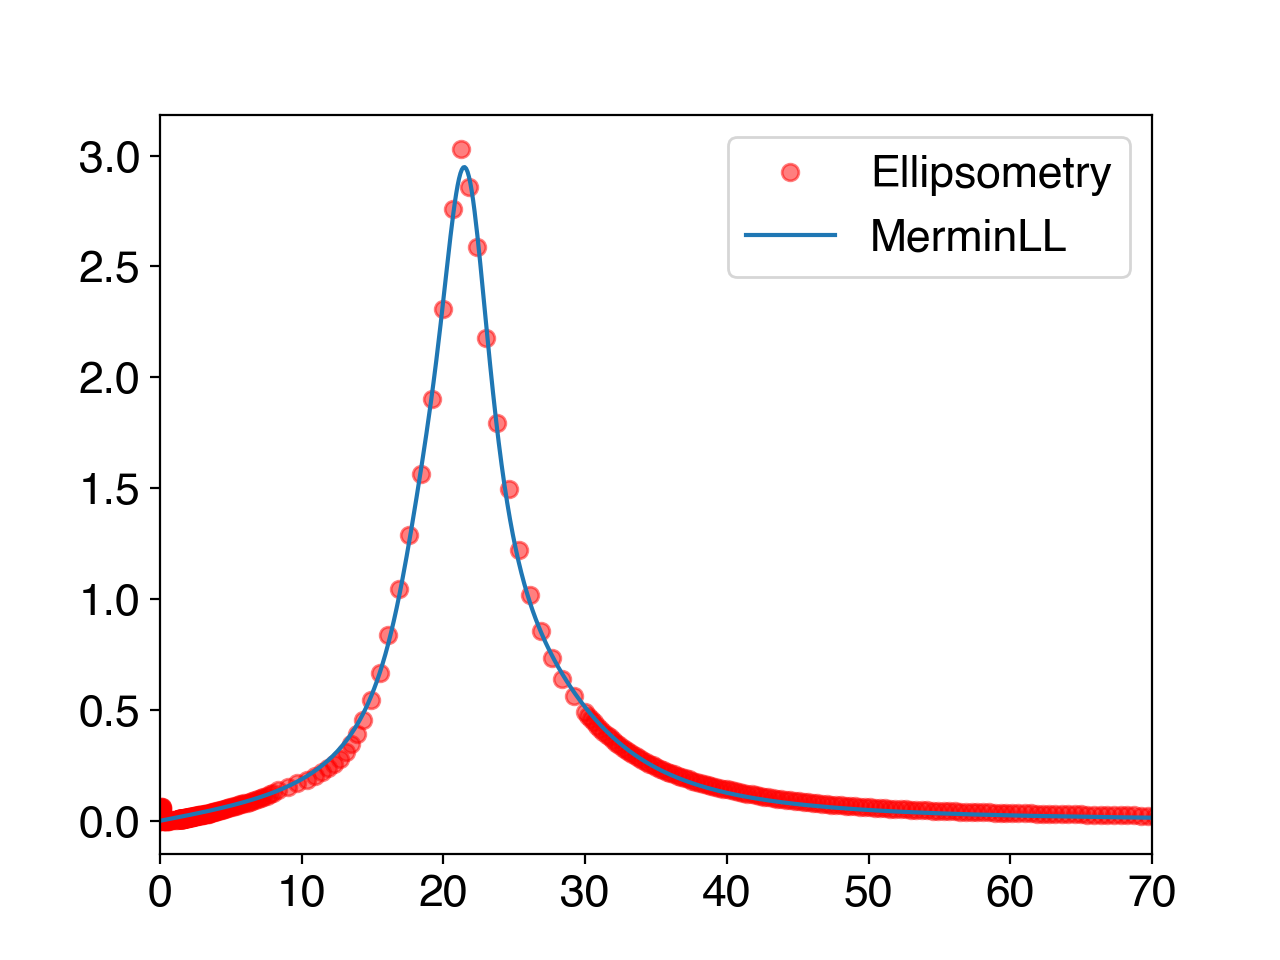

In [33]:
sic_mll.calculateELF()

plt.figure()
plt.plot(exp_data.x_elf, exp_data.y_elf,'o', c='red', alpha=0.5, label='Ellipsometry')
plt.plot(sic_mll.eloss, sic_mll.ELF, label=sic_mll.oscillators.model)
plt.xlim(0,70)
plt.legend()
plt.show()